In [74]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import nearest_points
import alphashape
from skimage.segmentation import flood_fill

In [2]:
FILE = "./data/room_big2.ply"

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
s_val = PointCloudDataset(FILE)

In [5]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [6]:
# sem_seg.visualize_pcd()

### Step 2: Detect Floor & Ceiling

In [7]:
sem_seg.ransac_segment()

Starting structural segmentation...
Detecting floor and ceiling...
  Floor found: 267684 points
  Ceiling found: 245893 points
Segmentation complete in 11.57 seconds
Found: 2 structural elements
  floor: 1
  ceiling: 1
Remaining unsegmented points: 995642


In [ ]:
# sem_seg.ransac_segmentor.visualize_segments()

PointCloud with 1509219 points.

In [9]:
n = sem_seg.ransac_segmentor.segments["ceiling"]["plane"]["normal"]
target = np.array([0., 0., -1.])
angle = np.degrees(np.arccos(np.clip(np.abs(np.dot(n, target)), -1, 1)))
angle

np.float64(0.14286286250574126)

### Step 3: Extract Wall Points

In [17]:
remainig_ind = sem_seg.ransac_segmentor.remaining_indices

In [18]:
points = sem_seg.points[remainig_ind]

In [19]:
def extract_wall_points(points, floor_height, ceiling_height, 
                       floor_margin=0.1, ceiling_margin=0.1):
    """
    Keep only points between floor and ceiling (potential walls)
    
    Args:
        points: Nx3 array
        floor_height: float
        ceiling_height: float
        floor_margin: Distance above floor to include (m)
        ceiling_margin: Distance below ceiling to include (m)
    
    Returns:
        wall_points: Filtered points
        wall_mask: Boolean mask
    """
    z_values = points[:, 2]
    
    wall_mask = (z_values > floor_height + floor_margin) & \
                (z_values < ceiling_height - ceiling_margin)
    
    wall_points = points[wall_mask]
    
    print(f"Original points: {len(points)}")
    print(f"Wall points: {len(wall_points)} ({100*len(wall_points)/len(points):.1f}%)")
    
    return wall_points, wall_mask

In [20]:
def visualize_wall_points(wall_points):
    """Visualize extracted wall points"""
    pcd_walls = o3d.geometry.PointCloud()
    pcd_walls.points = o3d.utility.Vector3dVector(wall_points)
    pcd_walls.paint_uniform_color([0, 1, 0])  # Green
    
    o3d.visualization.draw_geometries([pcd_walls], 
                                      window_name="Wall Points (Green)")

In [21]:
floor_h, ceiling_h = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [22]:
floor_h, ceiling_h

(np.float64(-1.344431407101391), np.float64(1.2913285427865726))

In [23]:
wall_points, wall_mask = extract_wall_points(points[:, :3], floor_h, ceiling_h)

Original points: 995642
Wall points: 949310 (95.3%)


In [24]:
# visualize_wall_points(wall_points)

### Step 4: Filter Vertical Points

In [25]:
def compute_normals(points, radius=0.1, max_nn=30):
    """
    Compute normal vectors for each point
    
    Args:
        points: Nx3 array
        radius: Search radius for normal estimation
        max_nn: Max number of neighbors
    
    Returns:
        normals: Nx3 array of normal vectors
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=radius, 
            max_nn=max_nn
        )
    )
    
    # Orient normals consistently (optional but helpful)
    pcd.orient_normals_consistent_tangent_plane(k=15)
    
    normals = np.asarray(pcd.normals)
    
    print(f"Computed normals for {len(normals)} points")
    
    return normals, pcd

In [26]:
def filter_vertical_points(points, normals, vertical_threshold=0.1):
    """
    Keep only points with vertical normals (walls)
    
    Args:
        points: Nx3 array
        normals: Nx3 array
        vertical_threshold: Max abs(normal_z) for vertical surfaces
    
    Returns:
        vertical_points: Filtered points
        vertical_normals: Corresponding normals
        vertical_mask: Boolean mask
    """
    # Vertical surfaces have normals with small Z component
    normal_z = np.abs(normals[:, 2])
    vertical_mask = normal_z < vertical_threshold
    
    vertical_points = points[vertical_mask]
    vertical_normals = normals[vertical_mask]
    
    print(f"Wall points: {len(points)}")
    print(f"Vertical wall points: {len(vertical_points)} "
          f"({100*len(vertical_points)/len(points):.1f}%)")
    
    return vertical_points, vertical_normals, vertical_mask

In [27]:
normals, pcd_with_normals = compute_normals(wall_points)

Computed normals for 949310 points


In [28]:
vertical_points, vertical_normals, vert_mask = filter_vertical_points(
    wall_points, normals
)

Wall points: 949310
Vertical wall points: 497240 (52.4%)


In [29]:
pcd_vert = o3d.geometry.PointCloud()
pcd_vert.points = o3d.utility.Vector3dVector(vertical_points)
pcd_vert.normals = o3d.utility.Vector3dVector(vertical_normals)
pcd_vert.paint_uniform_color([1, 0, 1])  # Magenta
# o3d.visualization.draw_geometries([pcd_vert], window_name="Vertical Wall Points")

PointCloud with 497240 points.

### ROOM SEGMENTATION

In [48]:
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.spatial.distance import cdist

In [49]:
class WallRegionGrowing:
    """
    Region growing for wall segmentation using planarity and normal consistency
    """
    
    def __init__(self, 
                 distance_threshold=0.02,
                 normal_angle_threshold=15.0,
                 min_region_size=100,
                 neighbor_radius=0.10,
                 max_iterations=50,
                 verbose=True):
        """
        Parameters:
        -----------
        distance_threshold : float
            Maximum distance from point to plane (meters)
        normal_angle_threshold : float
            Maximum angle difference between normals (degrees)
        min_region_size : int
            Minimum points required for valid region
        neighbor_radius : float
            Search radius for neighbors (meters)
        max_iterations : int
            Maximum growing iterations per region
        verbose : bool
            Print progress information
        """
        self.distance_threshold = distance_threshold
        self.normal_angle_threshold = normal_angle_threshold
        self.normal_threshold_cos = np.cos(np.radians(normal_angle_threshold))
        self.min_region_size = min_region_size
        self.neighbor_radius = neighbor_radius
        self.max_iterations = max_iterations
        self.verbose = verbose
        
        # Results
        self.labels = None
        self.regions = []
        self.plane_params = []
        self.region_info = {}
        
    
    def fit_plane_to_points(self, points):
        """
        Fit plane to point set using SVD (robust)
        
        Returns:
        --------
        normal : np.ndarray, shape (3,)
            Unit normal vector of plane
        centroid : np.ndarray, shape (3,)
            Centroid of points
        """
        centroid = points.mean(axis=0)
        centered = points - centroid
        
        # SVD to find best-fit plane
        _, _, vh = np.linalg.svd(centered)
        normal = vh[-1]  # Normal is last singular vector
        
        # Ensure unit length
        normal = normal / np.linalg.norm(normal)
        
        return normal, centroid
    
    
    def point_to_plane_distance(self, points, normal, centroid):
        """
        Compute signed distance from points to plane
        
        Parameters:
        -----------
        points : np.ndarray, shape (N, 3)
        normal : np.ndarray, shape (3,)
        centroid : np.ndarray, shape (3,)
        
        Returns:
        --------
        distances : np.ndarray, shape (N,)
            Signed distances (absolute value for distance to plane)
        """
        return np.abs(np.dot(points - centroid, normal))
    
    
    def check_normal_consistency(self, point_normals, region_normal):
        """
        Check if point normals are consistent with region normal
        
        Parameters:
        -----------
        point_normals : np.ndarray, shape (N, 3)
        region_normal : np.ndarray, shape (3,)
        
        Returns:
        --------
        consistent : np.ndarray, shape (N,) bool
            True if normal is consistent (angle < threshold)
        """
        # Compute dot product (cosine of angle)
        dot_products = np.abs(np.dot(point_normals, region_normal))
        
        # Check if angle is below threshold
        return dot_products >= self.normal_threshold_cos
    
    
    def grow_region(self, seed_idx, points, normals, assigned, kdtree):
        """
        Grow a planar region from seed point
        
        Parameters:
        -----------
        seed_idx : int
            Index of seed point
        points : np.ndarray, shape (N, 3)
        normals : np.ndarray, shape (N, 3)
        assigned : np.ndarray, shape (N,) bool
            Already assigned points
        kdtree : KDTree
            Spatial index for neighbor search
        
        Returns:
        --------
        region_indices : np.ndarray
            Indices of points in this region
        plane_normal : np.ndarray, shape (3,)
        plane_centroid : np.ndarray, shape (3,)
        """
        
        # Initialize region with seed
        region_indices = [seed_idx]
        assigned[seed_idx] = True
        
        # Fit initial plane to seed and its neighbors
        neighbor_indices = kdtree.query_radius(points[seed_idx:seed_idx+1], 
                                               r=self.neighbor_radius)[0]
        neighbor_indices = neighbor_indices[~assigned[neighbor_indices]]
        
        if len(neighbor_indices) < 3:
            return np.array([seed_idx]), normals[seed_idx], points[seed_idx]
        
        initial_points = points[neighbor_indices]
        plane_normal, plane_centroid = self.fit_plane_to_points(initial_points)
        
        # Growing loop
        iteration = 0
        frontier = set(region_indices)
        
        while frontier and iteration < self.max_iterations:
            iteration += 1
            new_frontier = set()
            
            # Get neighbors of all frontier points
            frontier_points = points[list(frontier)]
            all_neighbors = kdtree.query_radius(frontier_points, 
                                               r=self.neighbor_radius)
            
            # Collect unique unassigned neighbors
            candidate_indices = set()
            for neighbors in all_neighbors:
                for idx in neighbors:
                    if not assigned[idx]:
                        candidate_indices.add(idx)
            
            if not candidate_indices:
                break
            
            candidate_indices = np.array(list(candidate_indices))
            candidate_points = points[candidate_indices]
            candidate_normals = normals[candidate_indices]
            
            # Check planarity (distance to plane)
            distances = self.point_to_plane_distance(candidate_points, 
                                                     plane_normal, 
                                                     plane_centroid)
            planar_mask = distances < self.distance_threshold
            
            # Check normal consistency
            normal_mask = self.check_normal_consistency(candidate_normals, 
                                                        plane_normal)
            
            # Accept points that pass both tests
            accept_mask = planar_mask & normal_mask
            accepted_indices = candidate_indices[accept_mask]
            
            if len(accepted_indices) == 0:
                break
            
            # Add to region
            region_indices.extend(accepted_indices)
            assigned[accepted_indices] = True
            new_frontier.update(accepted_indices)
            
            # Update plane with all region points
            region_points = points[region_indices]
            plane_normal, plane_centroid = self.fit_plane_to_points(region_points)
            
            frontier = new_frontier
        
        region_indices = np.array(region_indices)
        return region_indices, plane_normal, plane_centroid
    
    
    def fit(self, points, normals):
        """
        Segment wall points into planar regions
        
        Parameters:
        -----------
        points : np.ndarray, shape (N, 3)
            Wall point coordinates
        normals : np.ndarray, shape (N, 3)
            Wall point normals (should be unit vectors)
        
        Returns:
        --------
        self
        """
        n_points = len(points)
        
        if self.verbose:
            print(f"{'='*70}")
            print(f"REGION GROWING WALL SEGMENTATION")
            print(f"{'='*70}")
            print(f"Input points: {n_points:,}")
            print(f"Parameters:")
            print(f"  Distance threshold: {self.distance_threshold}m")
            print(f"  Normal angle threshold: {self.normal_angle_threshold}°")
            print(f"  Min region size: {self.min_region_size}")
            print(f"  Neighbor radius: {self.neighbor_radius}m")
            print(f"  Max iterations: {self.max_iterations}")
        
        start_time = time.time()
        
        # Normalize normals (just in case)
        normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
        
        # Build KD-tree for fast neighbor search
        if self.verbose:
            print(f"\nBuilding KD-tree...")
        kdtree = KDTree(points)
        
        # Initialize
        assigned = np.zeros(n_points, dtype=bool)
        self.labels = np.full(n_points, -1, dtype=int)
        self.regions = []
        self.plane_params = []
        
        region_id = 0
        
        if self.verbose:
            print(f"\nGrowing regions...")
        
        # Main region growing loop
        while not assigned.all():
            # Pick unassigned point with highest density (good seed)
            unassigned_indices = np.where(~assigned)[0]
            
            if len(unassigned_indices) == 0:
                break
            
            # Simple strategy: pick random unassigned point
            seed_idx = np.random.choice(unassigned_indices)
            
            # Grow region from seed
            region_indices, plane_normal, plane_centroid = self.grow_region(
                seed_idx, points, normals, assigned, kdtree
            )
            
            # Accept region if large enough
            if len(region_indices) >= self.min_region_size:
                self.regions.append(region_indices)
                self.plane_params.append({
                    'normal': plane_normal,
                    'centroid': plane_centroid
                })
                self.labels[region_indices] = region_id
                
                if self.verbose and region_id % 5 == 0:
                    pct_done = 100 * assigned.sum() / n_points
                    print(f"  Region {region_id}: {len(region_indices):,} points "
                          f"({pct_done:.1f}% complete)")
                
                region_id += 1
            else:
                # Mark as noise (too small)
                assigned[region_indices] = True
        
        elapsed = time.time() - start_time
        
        # Compute statistics
        n_regions = len(self.regions)
        n_assigned = (self.labels >= 0).sum()
        n_noise = n_points - n_assigned
        
        if self.verbose:
            print(f"\nRegion growing completed in {elapsed:.2f}s")
            print(f"  Regions found: {n_regions}")
            print(f"  Points assigned: {n_assigned:,} ({100*n_assigned/n_points:.1f}%)")
            print(f"  Noise points: {n_noise:,} ({100*n_noise/n_points:.1f}%)")
        
        # Compute region info
        self._compute_region_info(points)
        
        return self
    
    
    def _compute_region_info(self, points):
        """Compute statistics for each region"""
        
        self.region_info = {}
        
        for region_id, region_indices in enumerate(self.regions):
            region_points = points[region_indices]
            
            self.region_info[region_id] = {
                'n_points': len(region_indices),
                'centroid': region_points.mean(axis=0),
                'bbox_min': region_points.min(axis=0),
                'bbox_max': region_points.max(axis=0),
                'std': region_points.std(axis=0),
                'plane_normal': self.plane_params[region_id]['normal'],
                'plane_centroid': self.plane_params[region_id]['centroid']
            }
        
        if self.verbose:
            print(f"\nRegion size distribution:")
            sizes = [info['n_points'] for info in self.region_info.values()]
            if sizes:
                print(f"  Min: {min(sizes):,} points")
                print(f"  Max: {max(sizes):,} points")
                print(f"  Mean: {np.mean(sizes):,.0f} points")
                print(f"  Median: {np.median(sizes):,.0f} points")


def visualize_regions_3d(points, labels, n_regions, title="Wall Regions (3D)"):
    """Visualize regions in 3D"""
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate colors
    colors = plt.cm.tab20(np.linspace(0, 1, n_regions))
    
    # Plot each region
    for region_id in range(n_regions):
        mask = labels == region_id
        region_points = points[mask]
        
        ax.scatter(region_points[:, 0], 
                  region_points[:, 1], 
                  region_points[:, 2],
                  c=[colors[region_id]], 
                  s=1, 
                  alpha=0.6,
                  label=f'Region {region_id}')
    
    # Plot noise
    noise_mask = labels == -1
    if noise_mask.any():
        noise_points = points[noise_mask]
        ax.scatter(noise_points[:, 0], 
                  noise_points[:, 1], 
                  noise_points[:, 2],
                  c='black', 
                  s=0.5, 
                  alpha=0.3,
                  label='Noise')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(title)
    
    if n_regions <= 10:
        ax.legend(markerscale=5, loc='upper right')
    
    plt.tight_layout()
    return fig


def visualize_regions_2d(points, labels, n_regions, title="Wall Regions (Top View)"):
    """Visualize regions in 2D top-down view"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Generate colors
    colors = plt.cm.tab20(np.linspace(0, 1, n_regions))
    
    # Plot each region
    for region_id in range(n_regions):
        mask = labels == region_id
        region_points = points[mask]
        
        ax.scatter(region_points[:, 0], 
                  region_points[:, 1],
                  c=[colors[region_id]], 
                  s=2, 
                  alpha=0.7,
                  label=f'Region {region_id}')
    
    # Plot noise
    noise_mask = labels == -1
    if noise_mask.any():
        noise_points = points[noise_mask]
        ax.scatter(noise_points[:, 0], 
                  noise_points[:, 1],
                  c='black', 
                  s=1, 
                  alpha=0.3,
                  label='Noise')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if n_regions <= 10:
        ax.legend(markerscale=3, loc='upper right')
    
    plt.tight_layout()
    return fig


def print_region_details(region_info, max_regions=20):
    """Print detailed region statistics"""
    
    print(f"\n{'='*70}")
    print(f"REGION DETAILS")
    print(f"{'='*70}")
    
    # Sort by size
    sorted_regions = sorted(region_info.items(), 
                           key=lambda x: x[1]['n_points'], 
                           reverse=True)
    
    for i, (region_id, info) in enumerate(sorted_regions[:max_regions]):
        print(f"\nRegion {region_id}:")
        print(f"  Points: {info['n_points']:,}")
        print(f"  Centroid: [{info['centroid'][0]:.2f}, {info['centroid'][1]:.2f}, {info['centroid'][2]:.2f}]")
        
        bbox_size = info['bbox_max'] - info['bbox_min']
        print(f"  Bounding box: {bbox_size[0]:.2f}m × {bbox_size[1]:.2f}m × {bbox_size[2]:.2f}m")
        
        normal = info['plane_normal']
        print(f"  Plane normal: [{normal[0]:.3f}, {normal[1]:.3f}, {normal[2]:.3f}]")
    
    if len(sorted_regions) > max_regions:
        print(f"\n... and {len(sorted_regions) - max_regions} more regions")


def run_region_growing_pipeline(wall_points, wall_normals,
                                distance_threshold=0.02,
                                normal_angle_threshold=15.0,
                                min_region_size=100,
                                neighbor_radius=0.10,
                                show_3d=True,
                                show_2d=True,
                                show_details=True):
    """
    Complete region growing pipeline
    
    Parameters:
    -----------
    wall_points : np.ndarray, shape (N, 3)
        Wall point coordinates
    wall_normals : np.ndarray, shape (N, 3)
        Wall point normals
    distance_threshold : float
        Max distance to plane (meters)
    normal_angle_threshold : float
        Max normal angle difference (degrees)
    min_region_size : int
        Minimum points per region
    neighbor_radius : float
        Neighbor search radius (meters)
    show_3d : bool
        Show 3D visualization
    show_2d : bool
        Show 2D visualization
    show_details : bool
        Print detailed statistics
    
    Returns:
    --------
    segmenter : WallRegionGrowing
        Fitted segmenter with results
    """
    
    # Create and fit segmenter
    segmenter = WallRegionGrowing(
        distance_threshold=distance_threshold,
        normal_angle_threshold=normal_angle_threshold,
        min_region_size=min_region_size,
        neighbor_radius=neighbor_radius,
        verbose=True
    )
    
    segmenter.fit(wall_points, wall_normals)
    
    # Print details
    if show_details:
        print_region_details(segmenter.region_info)
    
    # Visualize
    n_regions = len(segmenter.regions)
    
    if show_3d:
        fig_3d = visualize_regions_3d(wall_points, segmenter.labels, n_regions)
        plt.show()
    
    if show_2d:
        fig_2d = visualize_regions_2d(wall_points, segmenter.labels, n_regions)
        plt.show()
    
    return segmenter

REGION GROWING WALL SEGMENTATION
Input points: 497,240
Parameters:
  Distance threshold: 0.03m
  Normal angle threshold: 20.0°
  Min region size: 500
  Neighbor radius: 0.12m
  Max iterations: 50

Building KD-tree...

Growing regions...
  Region 0: 12,446 points (2.5% complete)
  Region 5: 12,281 points (10.9% complete)
  Region 10: 2,888 points (23.6% complete)
  Region 15: 6,525 points (32.9% complete)
  Region 20: 12,874 points (40.6% complete)
  Region 25: 9,481 points (48.0% complete)
  Region 30: 1,096 points (54.4% complete)
  Region 35: 4,429 points (59.1% complete)
  Region 40: 6,442 points (62.8% complete)
  Region 45: 1,604 points (66.7% complete)
  Region 50: 581 points (68.9% complete)
  Region 55: 1,938 points (73.4% complete)
  Region 60: 3,348 points (77.1% complete)
  Region 65: 2,509 points (78.8% complete)
  Region 70: 1,344 points (80.0% complete)
  Region 75: 523 points (81.3% complete)
  Region 80: 1,089 points (82.4% complete)
  Region 85: 1,559 points (84.1% com

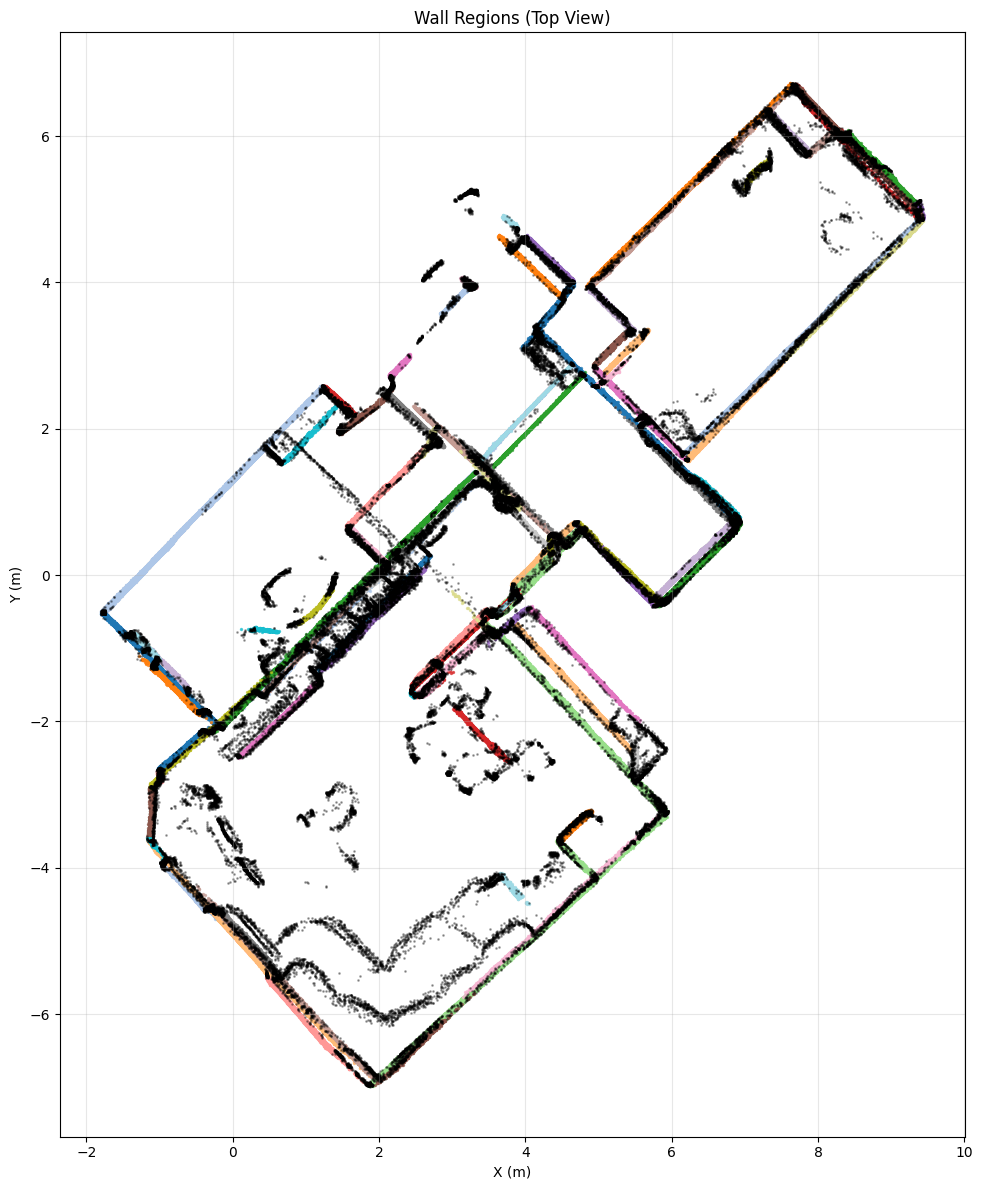

In [51]:
segmenter = run_region_growing_pipeline(
    vertical_points,
    vertical_normals,
    distance_threshold=0.03,      # 2cm to plane
    normal_angle_threshold=20.0,  # 15° max angle difference
    min_region_size=500,          # Min 100 points per wall
    neighbor_radius=0.12,         # 10cm neighbor search
    show_3d=False,
    show_2d=True,
    show_details=True
)

In [52]:
class RegionMerger:
    """
    Post-process region growing results to merge similar regions
    """
    
    def __init__(self,
                 normal_angle_threshold=10.0,
                 max_distance_threshold=0.30,
                 plane_distance_threshold=0.05,
                 min_final_region_size=500,
                 verbose=True):
        """
        Parameters:
        -----------
        normal_angle_threshold : float
            Maximum angle difference between region normals (degrees)
        max_distance_threshold : float
            Maximum distance between regions to consider merging (meters)
        plane_distance_threshold : float
            Maximum distance from one region's plane to other region's points (meters)
        min_final_region_size : int
            Minimum points in final merged regions
        verbose : bool
            Print progress
        """
        self.normal_angle_threshold = normal_angle_threshold
        self.normal_threshold_cos = np.cos(np.radians(normal_angle_threshold))
        self.max_distance_threshold = max_distance_threshold
        self.plane_distance_threshold = plane_distance_threshold
        self.min_final_region_size = min_final_region_size
        self.verbose = verbose
        
        # Results
        self.merged_labels = None
        self.merged_regions = []
        self.merged_plane_params = []
        self.merge_history = []
    
    
    def compute_plane_distance(self, points, normal, centroid):
        """Compute distance from points to plane"""
        return np.abs(np.dot(points - centroid, normal))
    
    
    def check_regions_coplanar(self, region_a_points, region_b_points,
                               normal_a, centroid_a, normal_b, centroid_b):
        """
        Check if two regions are coplanar
        
        Returns:
        --------
        coplanar : bool
        """
        # Check normal similarity
        dot_product = np.abs(np.dot(normal_a, normal_b))
        if dot_product < self.normal_threshold_cos:
            return False
        
        # Check if region B points fit region A plane
        distances_b_to_a = self.compute_plane_distance(region_b_points, normal_a, centroid_a)
        avg_dist_b_to_a = np.mean(distances_b_to_a)
        
        # Check if region A points fit region B plane
        distances_a_to_b = self.compute_plane_distance(region_a_points, normal_b, centroid_b)
        avg_dist_a_to_b = np.mean(distances_a_to_b)
        
        # Both should be close to each other's planes
        return (avg_dist_b_to_a < self.plane_distance_threshold and 
                avg_dist_a_to_b < self.plane_distance_threshold)
    
    
    def compute_region_distance(self, region_a_points, region_b_points):
        """
        Compute minimum distance between two regions
        Uses sampling for large regions
        """
        # Sample if regions are large (for speed)
        max_samples = 1000
        
        if len(region_a_points) > max_samples:
            indices_a = np.random.choice(len(region_a_points), max_samples, replace=False)
            sample_a = region_a_points[indices_a]
        else:
            sample_a = region_a_points
        
        if len(region_b_points) > max_samples:
            indices_b = np.random.choice(len(region_b_points), max_samples, replace=False)
            sample_b = region_b_points[indices_b]
        else:
            sample_b = region_b_points
        
        # Compute pairwise distances
        distances = cdist(sample_a, sample_b)
        min_distance = np.min(distances)
        
        return min_distance
    
    
    def fit_plane_to_points(self, points):
        """Fit plane using SVD"""
        centroid = points.mean(axis=0)
        centered = points - centroid
        _, _, vh = np.linalg.svd(centered)
        normal = vh[-1]
        normal = normal / np.linalg.norm(normal)
        return normal, centroid
    
    
    def merge_regions(self, points, labels, plane_params):
        """
        Merge similar regions
        
        Parameters:
        -----------
        points : np.ndarray, shape (N, 3)
            All points
        labels : np.ndarray, shape (N,)
            Region labels from region growing
        plane_params : list of dict
            Plane parameters for each region
        
        Returns:
        --------
        merged_labels : np.ndarray, shape (N,)
            New labels after merging
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"REGION MERGING POST-PROCESSOR")
            print(f"{'='*70}")
        
        start_time = time.time()
        
        # Get unique regions (excluding noise -1)
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[unique_labels >= 0]
        n_regions = len(unique_labels)
        
        if self.verbose:
            print(f"Input regions: {n_regions}")
            print(f"Parameters:")
            print(f"  Normal angle threshold: {self.normal_angle_threshold}°")
            print(f"  Max distance threshold: {self.max_distance_threshold}m")
            print(f"  Plane distance threshold: {self.plane_distance_threshold}m")
        
        # Build merge graph using Union-Find
        parent = {i: i for i in range(n_regions)}
        
        def find(x):
            if parent[x] != x:
                parent[x] = find(parent[x])
            return parent[x]
        
        def union(x, y):
            px, py = find(x), find(y)
            if px != py:
                parent[px] = py
                return True
            return False
        
        # Check all pairs of regions for merging
        if self.verbose:
            print(f"\nChecking region pairs for merging...")
        
        n_merges = 0
        for i in range(n_regions):
            for j in range(i + 1, n_regions):
                label_i = unique_labels[i]
                label_j = unique_labels[j]
                
                # Get region points
                mask_i = labels == label_i
                mask_j = labels == label_j
                points_i = points[mask_i]
                points_j = points[mask_j]
                
                # Get plane parameters
                normal_i = plane_params[label_i]['normal']
                centroid_i = plane_params[label_i]['centroid']
                normal_j = plane_params[label_j]['normal']
                centroid_j = plane_params[label_j]['centroid']
                
                # Check if regions should be merged
                # 1. Check spatial proximity
                min_dist = self.compute_region_distance(points_i, points_j)
                if min_dist > self.max_distance_threshold:
                    continue
                
                # 2. Check coplanarity
                coplanar = self.check_regions_coplanar(
                    points_i, points_j,
                    normal_i, centroid_i,
                    normal_j, centroid_j
                )
                
                if coplanar:
                    if union(i, j):
                        n_merges += 1
                        if self.verbose and n_merges % 10 == 0:
                            print(f"  Merged {n_merges} region pairs...")
        
        if self.verbose:
            print(f"  Total merges: {n_merges}")
        
        # Build merged region mapping
        merge_map = {}
        for i in range(n_regions):
            root = find(i)
            if root not in merge_map:
                merge_map[root] = []
            merge_map[root].append(unique_labels[i])
        
        n_merged_regions = len(merge_map)
        
        if self.verbose:
            print(f"\nMerged {n_regions} → {n_merged_regions} regions")
        
        # Create new labels
        self.merged_labels = np.full_like(labels, -1)
        self.merged_regions = []
        self.merged_plane_params = []
        
        new_label = 0
        for root, old_labels in merge_map.items():
            # Collect all points from merged regions
            merged_mask = np.isin(labels, old_labels)
            merged_points = points[merged_mask]
            
            # Skip if too small
            if len(merged_points) < self.min_final_region_size:
                continue
            
            # Assign new label
            self.merged_labels[merged_mask] = new_label
            
            # Recompute plane for merged region
            normal, centroid = self.fit_plane_to_points(merged_points)
            
            self.merged_regions.append(np.where(merged_mask)[0])
            self.merged_plane_params.append({
                'normal': normal,
                'centroid': centroid,
                'n_points': len(merged_points)
            })
            
            new_label += 1
        
        n_final_regions = len(self.merged_regions)
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            print(f"\nFinal regions after filtering: {n_final_regions}")
            print(f"Merging completed in {elapsed:.2f}s")
        
        return self.merged_labels
    
    
    def reassign_noise_points(self, points, labels, max_reassign_distance=0.10):
        """
        Reassign noise points to nearest region if close enough
        
        Parameters:
        -----------
        points : np.ndarray, shape (N, 3)
        labels : np.ndarray, shape (N,)
        max_reassign_distance : float
            Maximum distance to reassign noise to region (meters)
        
        Returns:
        --------
        updated_labels : np.ndarray, shape (N,)
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"REASSIGNING NOISE POINTS")
            print(f"{'='*70}")
        
        noise_mask = labels == -1
        n_noise_before = noise_mask.sum()
        
        if n_noise_before == 0:
            if self.verbose:
                print("No noise points to reassign")
            return labels
        
        if self.verbose:
            print(f"Noise points before: {n_noise_before:,} ({100*n_noise_before/len(labels):.1f}%)")
        
        # Get assigned points
        assigned_mask = labels >= 0
        assigned_points = points[assigned_mask]
        assigned_labels = labels[assigned_mask]
        
        # Build KD-tree on assigned points
        kdtree = KDTree(assigned_points)
        
        # Query nearest neighbors for noise points
        noise_points = points[noise_mask]
        distances, indices = kdtree.query(noise_points, k=1)
        
        # Reassign if close enough
        updated_labels = labels.copy()
        reassign_mask = distances.flatten() < max_reassign_distance
        
        noise_indices = np.where(noise_mask)[0]
        reassign_indices = noise_indices[reassign_mask]
        
        nearest_labels = assigned_labels[indices[reassign_mask].flatten()]
        updated_labels[reassign_indices] = nearest_labels
        
        n_reassigned = reassign_mask.sum()
        n_noise_after = (updated_labels == -1).sum()
        
        if self.verbose:
            print(f"Points reassigned: {n_reassigned:,}")
            print(f"Noise points after: {n_noise_after:,} ({100*n_noise_after/len(labels):.1f}%)")
        
        return updated_labels


def visualize_merged_regions_2d(points, labels, title="Merged Wall Regions (Top View)"):
    """Visualize merged regions in 2D"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Get unique labels
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels >= 0]
    n_regions = len(unique_labels)
    
    # Generate colors
    colors = plt.cm.tab20(np.linspace(0, 1, n_regions))
    
    # Plot each region
    for idx, region_id in enumerate(unique_labels):
        mask = labels == region_id
        region_points = points[mask]
        
        ax.scatter(region_points[:, 0], 
                  region_points[:, 1],
                  c=[colors[idx]], 
                  s=2, 
                  alpha=0.7,
                  label=f'Region {region_id}')
    
    # Plot noise
    noise_mask = labels == -1
    if noise_mask.any():
        noise_points = points[noise_mask]
        ax.scatter(noise_points[:, 0], 
                  noise_points[:, 1],
                  c='black', 
                  s=1, 
                  alpha=0.3,
                  label='Noise')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if n_regions <= 15:
        ax.legend(markerscale=3, loc='upper right', fontsize=8)
    
    plt.tight_layout()
    return fig


def visualize_merged_regions_3d(points, labels, title="Merged Wall Regions (3D)"):
    """Visualize merged regions in 3D"""
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique labels
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels >= 0]
    n_regions = len(unique_labels)
    
    # Generate colors
    colors = plt.cm.tab20(np.linspace(0, 1, n_regions))
    
    # Plot each region
    for idx, region_id in enumerate(unique_labels):
        mask = labels == region_id
        region_points = points[mask]
        
        ax.scatter(region_points[:, 0], 
                  region_points[:, 1], 
                  region_points[:, 2],
                  c=[colors[idx]], 
                  s=1, 
                  alpha=0.6,
                  label=f'Region {region_id}')
    
    # Plot noise
    noise_mask = labels == -1
    if noise_mask.any():
        noise_points = points[noise_mask]
        ax.scatter(noise_points[:, 0], 
                  noise_points[:, 1], 
                  noise_points[:, 2],
                  c='black', 
                  s=0.5, 
                  alpha=0.3,
                  label='Noise')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(title)
    
    if n_regions <= 15:
        ax.legend(markerscale=5, loc='upper right', fontsize=8)
    
    plt.tight_layout()
    return fig


def print_merged_region_stats(merged_labels, merged_plane_params):
    """Print statistics about merged regions"""
    
    print(f"\n{'='*70}")
    print(f"MERGED REGION STATISTICS")
    print(f"{'='*70}")
    
    n_regions = len(merged_plane_params)
    sizes = [param['n_points'] for param in merged_plane_params]
    
    print(f"\nTotal merged regions: {n_regions}")
    print(f"\nRegion size distribution:")
    print(f"  Min: {min(sizes):,} points")
    print(f"  Max: {max(sizes):,} points")
    print(f"  Mean: {np.mean(sizes):,.0f} points")
    print(f"  Median: {np.median(sizes):,.0f} points")
    
    # Print largest regions
    sorted_indices = np.argsort(sizes)[::-1]
    print(f"\nTop 10 largest regions:")
    for i, idx in enumerate(sorted_indices[:10]):
        param = merged_plane_params[idx]
        normal = param['normal']
        print(f"  Region {idx}: {param['n_points']:,} points, "
              f"normal=[{normal[0]:.3f}, {normal[1]:.3f}, {normal[2]:.3f}]")


def run_merge_pipeline(points, labels, plane_params,
                       normal_angle_threshold=10.0,
                       max_distance_threshold=0.30,
                       plane_distance_threshold=0.05,
                       reassign_noise=True,
                       max_reassign_distance=0.10,
                       show_3d=True,
                       show_2d=True):
    """
    Complete merging pipeline
    
    Parameters:
    -----------
    points : np.ndarray, shape (N, 3)
        Wall points
    labels : np.ndarray, shape (N,)
        Region labels from region growing
    plane_params : list of dict
        Plane parameters from region growing
    normal_angle_threshold : float
        Max angle between normals to merge (degrees)
    max_distance_threshold : float
        Max distance between regions to consider merging (meters)
    plane_distance_threshold : float
        Max distance from plane to consider coplanar (meters)
    reassign_noise : bool
        Reassign noise points to nearest region
    max_reassign_distance : float
        Max distance to reassign noise (meters)
    show_3d : bool
        Show 3D visualization
    show_2d : bool
        Show 2D visualization
    
    Returns:
    --------
    merger : RegionMerger
        Fitted merger with results
    final_labels : np.ndarray
        Final labels after merging and noise reassignment
    """
    
    # Create merger
    merger = RegionMerger(
        normal_angle_threshold=normal_angle_threshold,
        max_distance_threshold=max_distance_threshold,
        plane_distance_threshold=plane_distance_threshold,
        verbose=True
    )
    
    # Merge regions
    merged_labels = merger.merge_regions(points, labels, plane_params)
    
    # Reassign noise
    if reassign_noise:
        final_labels = merger.reassign_noise_points(
            points, 
            merged_labels,
            max_reassign_distance=max_reassign_distance
        )
    else:
        final_labels = merged_labels
    
    # Print statistics
    print_merged_region_stats(final_labels, merger.merged_plane_params)
    
    # Visualize
    if show_2d:
        fig_2d = visualize_merged_regions_2d(points, final_labels)
        plt.show()
    
    if show_3d:
        fig_3d = visualize_merged_regions_3d(points, final_labels)
        plt.show()
    
    return merger, final_labels


REGION MERGING POST-PROCESSOR
Input regions: 93
Parameters:
  Normal angle threshold: 35.0°
  Max distance threshold: 0.8m
  Plane distance threshold: 0.12m

Checking region pairs for merging...
  Merged 10 region pairs...
  Merged 20 region pairs...
  Merged 30 region pairs...
  Merged 40 region pairs...
  Total merges: 47

Merged 93 → 46 regions

Final regions after filtering: 46
Merging completed in 39.93s

REASSIGNING NOISE POINTS
Noise points before: 83,255 (16.7%)
Points reassigned: 68,184
Noise points after: 15,071 (3.0%)

MERGED REGION STATISTICS

Total merged regions: 46

Region size distribution:
  Min: 517 points
  Max: 41,967 points
  Mean: 9,000 points
  Median: 2,944 points

Top 10 largest regions:
  Region 3: 41,967 points, normal=[-0.693, 0.721, -0.011]
  Region 6: 41,896 points, normal=[0.713, -0.701, -0.005]
  Region 13: 35,121 points, normal=[0.705, -0.709, -0.007]
  Region 10: 26,546 points, normal=[-0.703, 0.711, -0.013]
  Region 7: 25,696 points, normal=[0.715, -

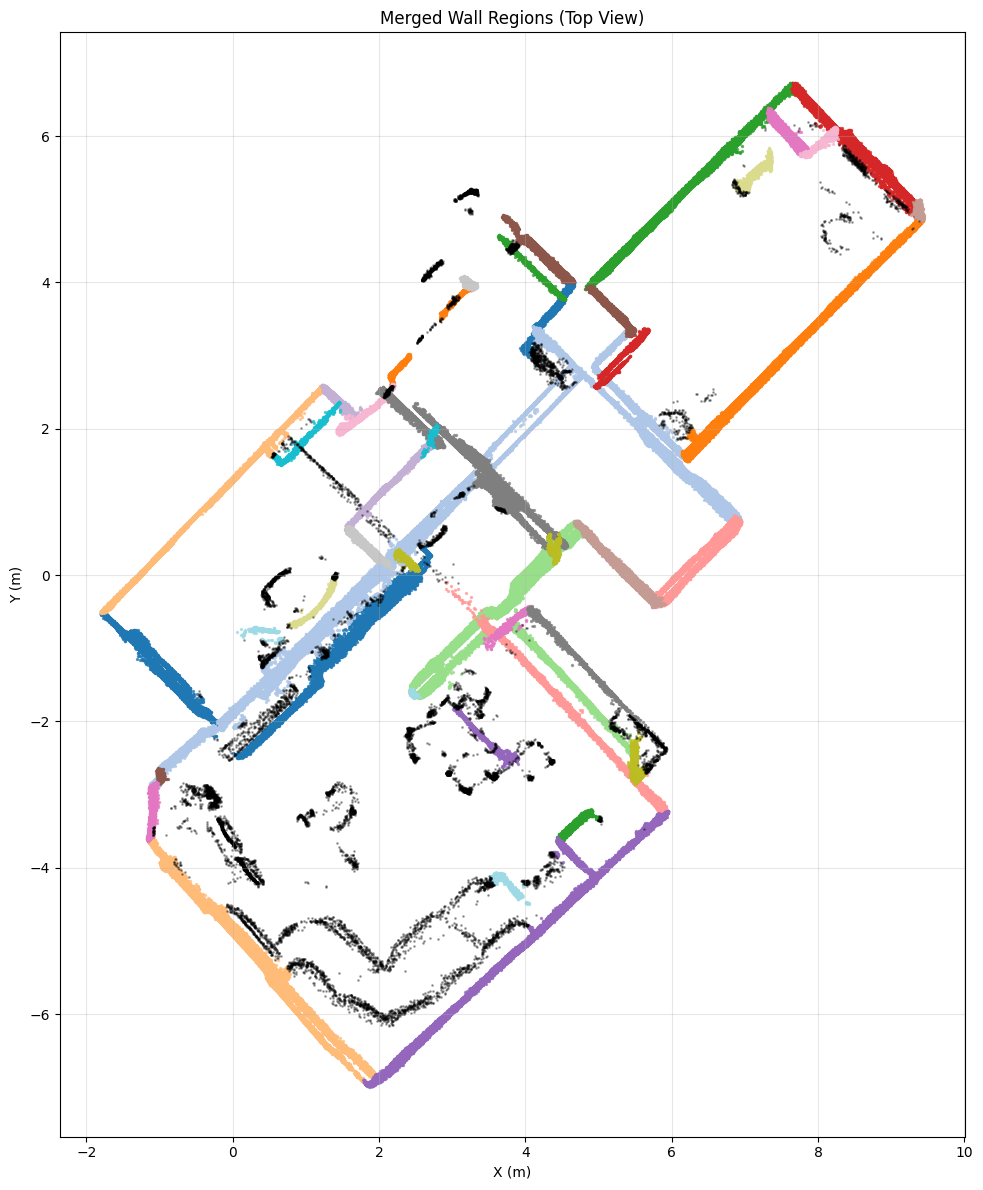

In [56]:
merger, final_labels = run_merge_pipeline(
    vertical_points,
    segmenter.labels,              # Your 93 region labels
    segmenter.plane_params,        # Plane parameters
    normal_angle_threshold=35.0,   # 10° - strict normal similarity
    max_distance_threshold=0.80,   # 30cm max distance between regions
    plane_distance_threshold=0.12   , # 5cm coplanarity tolerance
    reassign_noise=True,           # Clean up black points
    max_reassign_distance=0.15,    # 10cm max to reassign noise
    show_3d=False,
    show_2d=True
)

In [88]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KDTree
from scipy import ndimage
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.ops import unary_union
import time


class GraphRoomSeparator:
    """
    Separate rooms using graph-based segmentation with wall constraints
    """
    
    def __init__(self,
                 grid_resolution=0.05,
                 wall_distance_threshold=0.15,
                 n_rooms='auto',
                 min_room_area=2.0,
                 verbose=True):
        """
        Parameters:
        -----------
        grid_resolution : float
            Size of grid cells (meters)
        wall_distance_threshold : float
            Distance from walls to consider as boundary (meters)
        n_rooms : int or 'auto'
            Number of rooms to segment (auto = estimate from connectivity)
        min_room_area : float
            Minimum room area in square meters
        verbose : bool
            Print progress
        """
        self.grid_resolution = grid_resolution
        self.wall_distance_threshold = wall_distance_threshold
        self.n_rooms = n_rooms
        self.min_room_area = min_room_area
        self.verbose = verbose
        
        # Results
        self.occupancy_grid = None
        self.wall_distance_grid = None
        self.room_labels_grid = None
        self.room_polygons = []
        self.grid_bounds = None
        
    
    def create_occupancy_grid(self, floor_points, wall_points):
        """
        Create 2D occupancy grid from floor and wall points
        
        Parameters:
        -----------
        floor_points : np.ndarray, shape (N, 3)
            Floor point coordinates
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        occupancy_grid : np.ndarray, shape (H, W)
            1 = floor (walkable), 0 = wall/empty
        grid_bounds : dict
            Grid coordinate bounds
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"CREATING OCCUPANCY GRID")
            print(f"{'='*70}")
        
        # Get 2D coordinates (X, Y)
        all_points = np.vstack([floor_points[:, :2], wall_points[:, :2]])
        
        # Compute grid bounds
        min_x, min_y = all_points.min(axis=0)
        max_x, max_y = all_points.max(axis=0)
        
        # Add padding
        padding = 0.5  # 50cm padding
        min_x -= padding
        min_y -= padding
        max_x += padding
        max_y += padding
        
        # Compute grid dimensions
        width = int(np.ceil((max_x - min_x) / self.grid_resolution))
        height = int(np.ceil((max_y - min_y) / self.grid_resolution))
        
        self.grid_bounds = {
            'min_x': min_x,
            'min_y': min_y,
            'max_x': max_x,
            'max_y': max_y,
            'width': width,
            'height': height
        }
        
        if self.verbose:
            print(f"Grid resolution: {self.grid_resolution}m")
            print(f"Grid dimensions: {width} x {height} = {width*height:,} cells")
            print(f"Bounds: X=[{min_x:.2f}, {max_x:.2f}], Y=[{min_y:.2f}, {max_y:.2f}]")
        
        # Initialize grid (0 = empty)
        occupancy_grid = np.zeros((height, width), dtype=np.uint8)
        
        # Rasterize floor points (mark as 1 = walkable)
        floor_2d = floor_points[:, :2]
        grid_x = ((floor_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
        grid_y = ((floor_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
        
        # Clip to grid bounds
        valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
        grid_x = grid_x[valid]
        grid_y = grid_y[valid]
        
        occupancy_grid[grid_y, grid_x] = 1
        
        # Rasterize wall points (mark as 0 = obstacle)
        wall_2d = wall_points[:, :2]
        grid_x = ((wall_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
        grid_y = ((wall_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
        
        valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
        grid_x = grid_x[valid]
        grid_y = grid_y[valid]
        
        occupancy_grid[grid_y, grid_x] = 0
        
        # Apply morphological operations to clean up
        # Close small holes in floor
        occupancy_grid = ndimage.binary_closing(occupancy_grid, iterations=2).astype(np.uint8)
        
        # Remove small isolated regions
        occupancy_grid = ndimage.binary_opening(occupancy_grid, iterations=1).astype(np.uint8)
        
        n_floor_cells = np.sum(occupancy_grid)
        floor_area = n_floor_cells * (self.grid_resolution ** 2)
        
        if self.verbose:
            print(f"Floor cells: {n_floor_cells:,} ({100*n_floor_cells/(width*height):.1f}%)")
            print(f"Floor area: {floor_area:.2f} m²")
        
        self.occupancy_grid = occupancy_grid
        return occupancy_grid, self.grid_bounds
    
    
    def compute_wall_distance_field(self, wall_points):
        """
        Compute distance from each grid cell to nearest wall
        
        Parameters:
        -----------
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        distance_grid : np.ndarray, shape (H, W)
            Distance to nearest wall for each cell
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"COMPUTING WALL DISTANCE FIELD")
            print(f"{'='*70}")
        
        height, width = self.occupancy_grid.shape
        min_x = self.grid_bounds['min_x']
        min_y = self.grid_bounds['min_y']
        
        # Create grid of cell centers
        x_coords = np.arange(width) * self.grid_resolution + min_x + self.grid_resolution/2
        y_coords = np.arange(height) * self.grid_resolution + min_y + self.grid_resolution/2
        xx, yy = np.meshgrid(x_coords, y_coords)
        
        grid_points = np.column_stack([xx.ravel(), yy.ravel()])
        
        # Build KD-tree on wall points (2D)
        wall_2d = wall_points[:, :2]
        kdtree = KDTree(wall_2d)
        
        # Query nearest wall for each grid cell
        if self.verbose:
            print(f"Computing distances for {len(grid_points):,} grid cells...")
        
        distances, _ = kdtree.query(grid_points, k=1)
        distance_grid = distances.reshape(height, width)
        
        if self.verbose:
            print(f"Distance range: [{distance_grid.min():.3f}, {distance_grid.max():.3f}] meters")
        
        self.wall_distance_grid = distance_grid
        return distance_grid
    
    
    def build_graph(self):
        """
        Build graph from occupancy grid with wall-based edge weights
        
        Returns:
        --------
        adjacency_matrix : scipy.sparse matrix
            Weighted adjacency matrix
        node_indices : np.ndarray
            Mapping from (y, x) to graph node index
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"BUILDING CONNECTIVITY GRAPH")
            print(f"{'='*70}")
        
        height, width = self.occupancy_grid.shape
        
        # Create node index mapping (only for floor cells)
        node_indices = np.full((height, width), -1, dtype=int)
        floor_mask = self.occupancy_grid > 0
        n_nodes = np.sum(floor_mask)
        node_indices[floor_mask] = np.arange(n_nodes)
        
        if self.verbose:
            print(f"Graph nodes: {n_nodes:,}")
        
        # Build adjacency list
        rows = []
        cols = []
        weights = []
        
        # 4-connectivity (up, down, left, right)
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        for y in range(height):
            for x in range(width):
                if not floor_mask[y, x]:
                    continue
                
                node_i = node_indices[y, x]
                
                # Check each neighbor
                for dy, dx in neighbors:
                    ny, nx = y + dy, x + dx
                    
                    # Check bounds
                    if ny < 0 or ny >= height or nx < 0 or nx >= width:
                        continue
                    
                    # Check if neighbor is floor
                    if not floor_mask[ny, nx]:
                        continue
                    
                    node_j = node_indices[ny, nx]
                    
                    # Compute edge weight based on wall proximity
                    # Higher weight = stronger connection = less likely to cut
                    # Lower weight = weaker connection = more likely to cut
                    
                    # Average distance to walls for both cells
                    dist_i = self.wall_distance_grid[y, x]
                    dist_j = self.wall_distance_grid[ny, nx]
                    avg_dist = (dist_i + dist_j) / 2
                    
                    # Weight function:
                    # - Far from walls (open space): high weight (don't cut)
                    # - Near walls (doorways): low weight (easy to cut)
                    # - Very close to walls: medium weight (boundary cells)
                    
                    if avg_dist > self.wall_distance_threshold:
                        # Open space - strong connection
                        weight = 1.0
                    else:
                        # Near walls - connection strength decreases with proximity
                        # At wall: weight ≈ 0.1
                        # At threshold: weight ≈ 1.0
                        weight = (avg_dist / self.wall_distance_threshold) ** 2
                        weight = max(0.1, weight)  # Minimum weight
                    
                    rows.append(node_i)
                    cols.append(node_j)
                    weights.append(weight)
        
        # Create sparse adjacency matrix
        adjacency_matrix = csr_matrix(
            (weights, (rows, cols)),
            shape=(n_nodes, n_nodes)
        )
        
        # Make symmetric
        adjacency_matrix = adjacency_matrix + adjacency_matrix.T
        
        if self.verbose:
            print(f"Graph edges: {len(weights):,}")
            print(f"Average degree: {2*len(weights)/n_nodes:.1f}")
        
        return adjacency_matrix, node_indices
    
    
    def estimate_n_rooms(self, adjacency_matrix):
        """
        Estimate number of rooms from graph connectivity
        """
        
        # Find connected components (rooms separated by walls with no doors)
        n_components, labels = connected_components(
            adjacency_matrix, 
            directed=False,
            return_labels=True
        )
        
        if self.verbose:
            print(f"\nEstimated {n_components} connected components")
        
        # Use 2-3x connected components as estimate (accounts for rooms with doors)
        estimated_rooms = max(3, min(15, n_components * 2))
        
        return estimated_rooms
    
    
    def segment_rooms(self, adjacency_matrix, node_indices):
        """
        Segment rooms using spectral clustering
        
        Parameters:
        -----------
        adjacency_matrix : scipy.sparse matrix
            Graph adjacency matrix
        node_indices : np.ndarray
            Node index mapping
        
        Returns:
        --------
        room_labels_grid : np.ndarray, shape (H, W)
            Room label for each grid cell (-1 = wall/empty)
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"SEGMENTING ROOMS")
            print(f"{'='*70}")
        
        # Determine number of rooms
        if self.n_rooms == 'auto':
            n_rooms = self.estimate_n_rooms(adjacency_matrix)
            if self.verbose:
                print(f"Auto-detected n_rooms: {n_rooms}")
        else:
            n_rooms = self.n_rooms
        
        # Apply spectral clustering
        if self.verbose:
            print(f"Running spectral clustering with {n_rooms} clusters...")
        
        clustering = SpectralClustering(
            n_clusters=n_rooms,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42,
            n_init=10
        )
        
        node_labels = clustering.fit_predict(adjacency_matrix)
        
        # Map back to grid
        height, width = self.occupancy_grid.shape
        room_labels_grid = np.full((height, width), -1, dtype=int)
        
        floor_mask = self.occupancy_grid > 0
        room_labels_grid[floor_mask] = node_labels
        
        # Filter small regions
        for room_id in range(n_rooms):
            mask = room_labels_grid == room_id
            area = np.sum(mask) * (self.grid_resolution ** 2)
            
            if area < self.min_room_area:
                if self.verbose:
                    print(f"  Filtering room {room_id} (area={area:.2f}m² < {self.min_room_area}m²)")
                room_labels_grid[mask] = -1
        
        # Renumber rooms
        unique_rooms = np.unique(room_labels_grid)
        unique_rooms = unique_rooms[unique_rooms >= 0]
        
        new_room_labels = np.full_like(room_labels_grid, -1)
        for new_id, old_id in enumerate(unique_rooms):
            new_room_labels[room_labels_grid == old_id] = new_id
        
        room_labels_grid = new_room_labels
        n_final_rooms = len(unique_rooms)
        
        if self.verbose:
            print(f"\nFinal rooms: {n_final_rooms}")
            for room_id in range(n_final_rooms):
                mask = room_labels_grid == room_id
                area = np.sum(mask) * (self.grid_resolution ** 2)
                print(f"  Room {room_id}: {area:.2f} m²")
        
        self.room_labels_grid = room_labels_grid
        return room_labels_grid
    
    
    def extract_room_polygons(self):
        """
        Extract polygon boundaries for each room
        
        Returns:
        --------
        room_polygons : list of shapely.Polygon
            Polygon for each room
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"EXTRACTING ROOM POLYGONS")
            print(f"{'='*70}")
        
        height, width = self.room_labels_grid.shape
        min_x = self.grid_bounds['min_x']
        min_y = self.grid_bounds['min_y']
        
        unique_rooms = np.unique(self.room_labels_grid)
        unique_rooms = unique_rooms[unique_rooms >= 0]
        
        room_polygons = []
        
        for room_id in unique_rooms:
            # Get room mask
            mask = (self.room_labels_grid == room_id).astype(np.uint8)
            
            # Find contours using connected components
            from skimage import measure
            contours = measure.find_contours(mask, 0.5)
            
            if len(contours) == 0:
                continue
            
            # Convert largest contour to polygon
            contour = max(contours, key=len)
            
            # Convert grid coordinates to world coordinates
            coords = []
            for point in contour:
                y, x = point
                world_x = x * self.grid_resolution + min_x
                world_y = y * self.grid_resolution + min_y
                coords.append([world_x, world_y])
            
            # Create polygon
            if len(coords) >= 3:
                poly = Polygon(coords)
                
                # Simplify polygon
                poly = poly.simplify(self.grid_resolution * 2, preserve_topology=True)
                
                if poly.is_valid and poly.area > 0:
                    room_polygons.append(poly)
                    
                    if self.verbose:
                        print(f"  Room {room_id}: {poly.area:.2f} m², {len(poly.exterior.coords)} vertices")
        
        self.room_polygons = room_polygons
        return room_polygons
    
    
    def fit(self, floor_points, wall_points):
        """
        Complete room separation pipeline
        
        Parameters:
        -----------
        floor_points : np.ndarray, shape (N, 3)
            Floor point coordinates
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        self
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"GRAPH-BASED ROOM SEPARATION PIPELINE")
            print(f"{'='*70}")
        
        start_time = time.time()
        
        # Step 1: Create occupancy grid
        self.create_occupancy_grid(floor_points, wall_points)
        
        # Step 2: Compute wall distance field
        self.compute_wall_distance_field(wall_points)
        
        # Step 3: Build graph
        adjacency_matrix, node_indices = self.build_graph()
        
        # Step 4: Segment rooms
        self.segment_rooms(adjacency_matrix, node_indices)
        
        # Step 5: Extract polygons
        self.extract_room_polygons()
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"Pipeline completed in {elapsed:.2f}s")
            print(f"Total rooms: {len(self.room_polygons)}")
            print(f"{'='*70}")
        
        return self


def visualize_occupancy_grid(occupancy_grid, grid_bounds, title="Occupancy Grid"):
    """Visualize occupancy grid"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    extent = [
        grid_bounds['min_x'],
        grid_bounds['max_x'],
        grid_bounds['min_y'],
        grid_bounds['max_y']
    ]
    
    ax.imshow(occupancy_grid, origin='lower', extent=extent, cmap='gray', alpha=0.8)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def visualize_room_segmentation(room_labels_grid, grid_bounds, title="Room Segmentation"):
    """Visualize room labels"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    extent = [
        grid_bounds['min_x'],
        grid_bounds['max_x'],
        grid_bounds['min_y'],
        grid_bounds['max_y']
    ]
    
    # Create color map
    masked_labels = np.ma.masked_where(room_labels_grid == -1, room_labels_grid)
    
    im = ax.imshow(masked_labels, origin='lower', extent=extent, 
                   cmap='tab20', alpha=0.8, interpolation='nearest')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Room ID')
    
    plt.tight_layout()
    return fig


def visualize_room_polygons(room_polygons, grid_bounds, title="Room Polygons"):
    """Visualize room polygons"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(room_polygons)))
    
    for i, poly in enumerate(room_polygons):
        if poly.exterior is None:
            continue
            
        coords = np.array(poly.exterior.coords)
        patch = MplPolygon(coords, facecolor=colors[i], edgecolor='black', 
                          linewidth=2, alpha=0.6, label=f'Room {i}')
        ax.add_patch(patch)
    
    ax.set_xlim(grid_bounds['min_x'], grid_bounds['max_x'])
    ax.set_ylim(grid_bounds['min_y'], grid_bounds['max_y'])
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if len(room_polygons) <= 15:
        ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    return fig


def run_room_separation_pipeline(floor_points, wall_points,
                                 grid_resolution=0.05,
                                 wall_distance_threshold=0.15,
                                 n_rooms='auto',
                                 min_room_area=2.0,
                                 show_occupancy=True,
                                 show_segmentation=True,
                                 show_polygons=True):
    """
    Complete room separation pipeline with visualization
    
    Parameters:
    -----------
    floor_points : np.ndarray, shape (N, 3)
        Floor point coordinates
    wall_points : np.ndarray, shape (M, 3)
        Wall point coordinates
    grid_resolution : float
        Grid cell size (meters)
    wall_distance_threshold : float
        Distance from walls for boundary detection (meters)
    n_rooms : int or 'auto'
        Number of rooms to segment
    min_room_area : float
        Minimum room area (m²)
    show_occupancy : bool
        Show occupancy grid
    show_segmentation : bool
        Show room segmentation
    show_polygons : bool
        Show room polygons
    
    Returns:
    --------
    separator : GraphRoomSeparator
        Fitted separator with results
    """
    
    # Create and fit separator
    separator = GraphRoomSeparator(
        grid_resolution=grid_resolution,
        wall_distance_threshold=wall_distance_threshold,
        n_rooms=n_rooms,
        min_room_area=min_room_area,
        verbose=True
    )
    
    separator.fit(floor_points, wall_points)
    
    # Visualizations
    if show_occupancy:
        fig_occ = visualize_occupancy_grid(
            separator.occupancy_grid,
            separator.grid_bounds
        )
        plt.show()
    
    if show_segmentation:
        fig_seg = visualize_room_segmentation(
            separator.room_labels_grid,
            separator.grid_bounds
        )
        plt.show()
    
    if show_polygons:
        fig_poly = visualize_room_polygons(
            separator.room_polygons,
            separator.grid_bounds
        )
        plt.show()
    
    return separator

In [93]:
floor_mask = sem_seg.ransac_segmentor.segments["floor"]["indices"]

In [94]:
floor_points = sem_seg.points[floor_mask][:, :3]


GRAPH-BASED ROOM SEPARATION PIPELINE

CREATING OCCUPANCY GRID
Grid resolution: 0.05m
Grid dimensions: 245 x 295 = 72,275 cells
Bounds: X=[-2.30, 9.95], Y=[-7.49, 7.23]
Floor cells: 17,059 (23.6%)
Floor area: 42.65 m²

COMPUTING WALL DISTANCE FIELD
Computing distances for 72,275 grid cells...
Distance range: [0.000, 5.767] meters

BUILDING CONNECTIVITY GRAPH
Graph nodes: 17,059
Graph edges: 65,852
Average degree: 7.7

SEGMENTING ROOMS

Estimated 3 connected components
Auto-detected n_rooms: 6
Running spectral clustering with 6 clusters...


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  Filtering room 2 (area=0.14m² < 2.0m²)

Final rooms: 5
  Room 0: 15.37 m²
  Room 1: 9.08 m²
  Room 2: 6.89 m²
  Room 3: 6.98 m²
  Room 4: 4.20 m²

EXTRACTING ROOM POLYGONS
  Room 0: 15.85 m², 49 vertices
  Room 1: 9.04 m², 16 vertices
  Room 2: 6.89 m², 27 vertices
  Room 3: 7.07 m², 21 vertices
  Room 4: 4.11 m², 19 vertices

Pipeline completed in 2.79s
Total rooms: 5


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


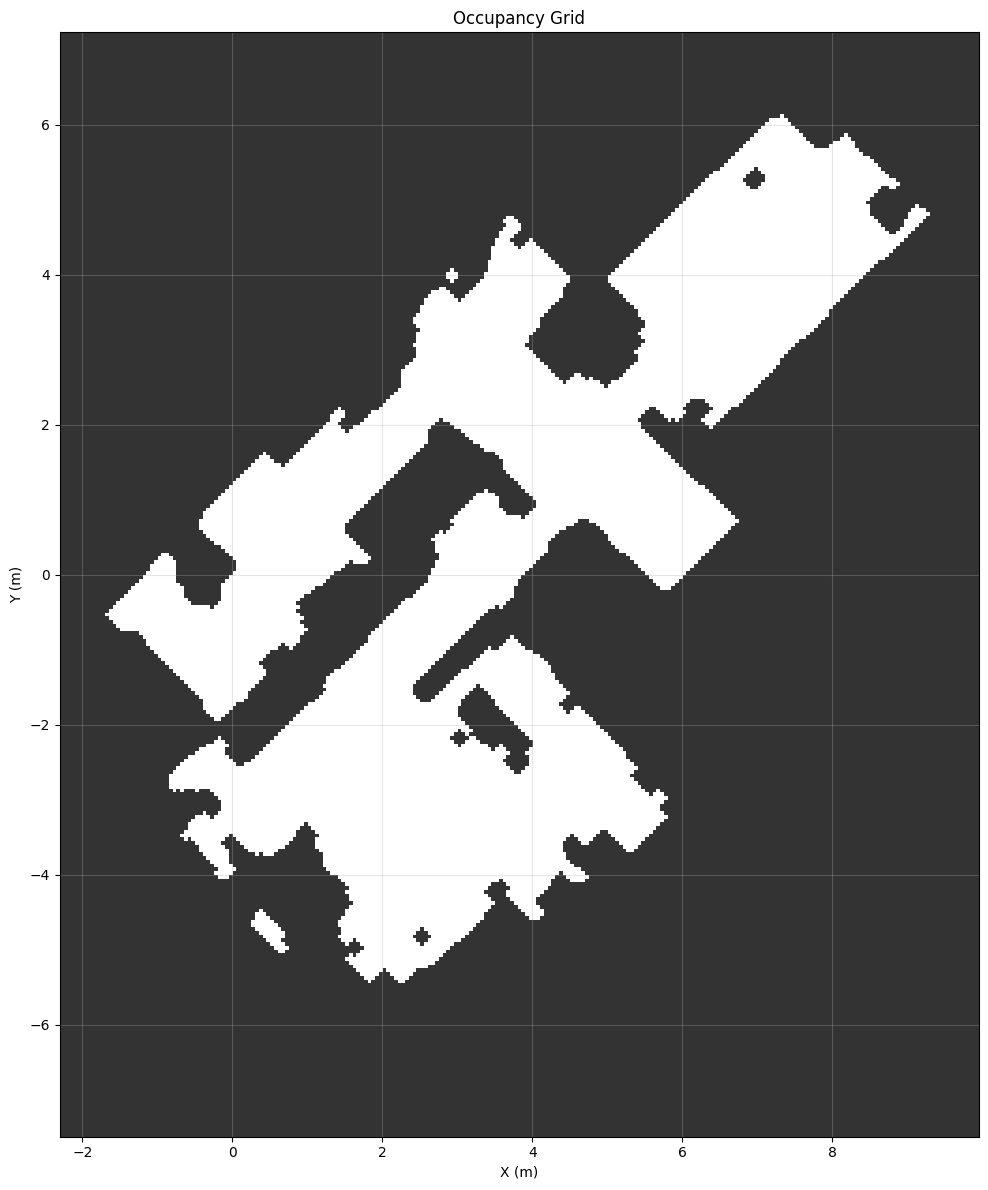

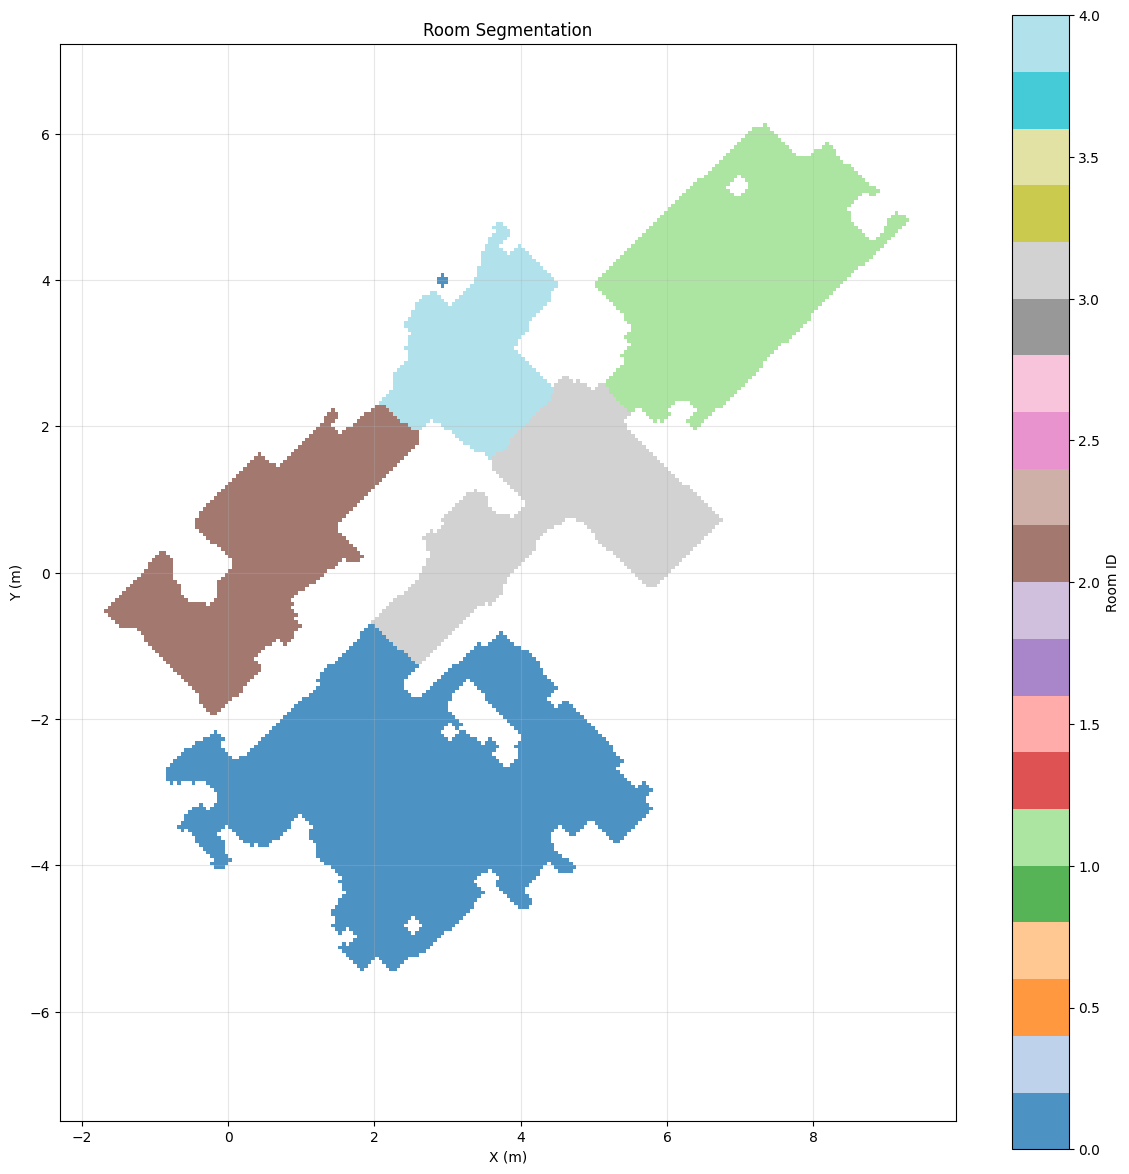

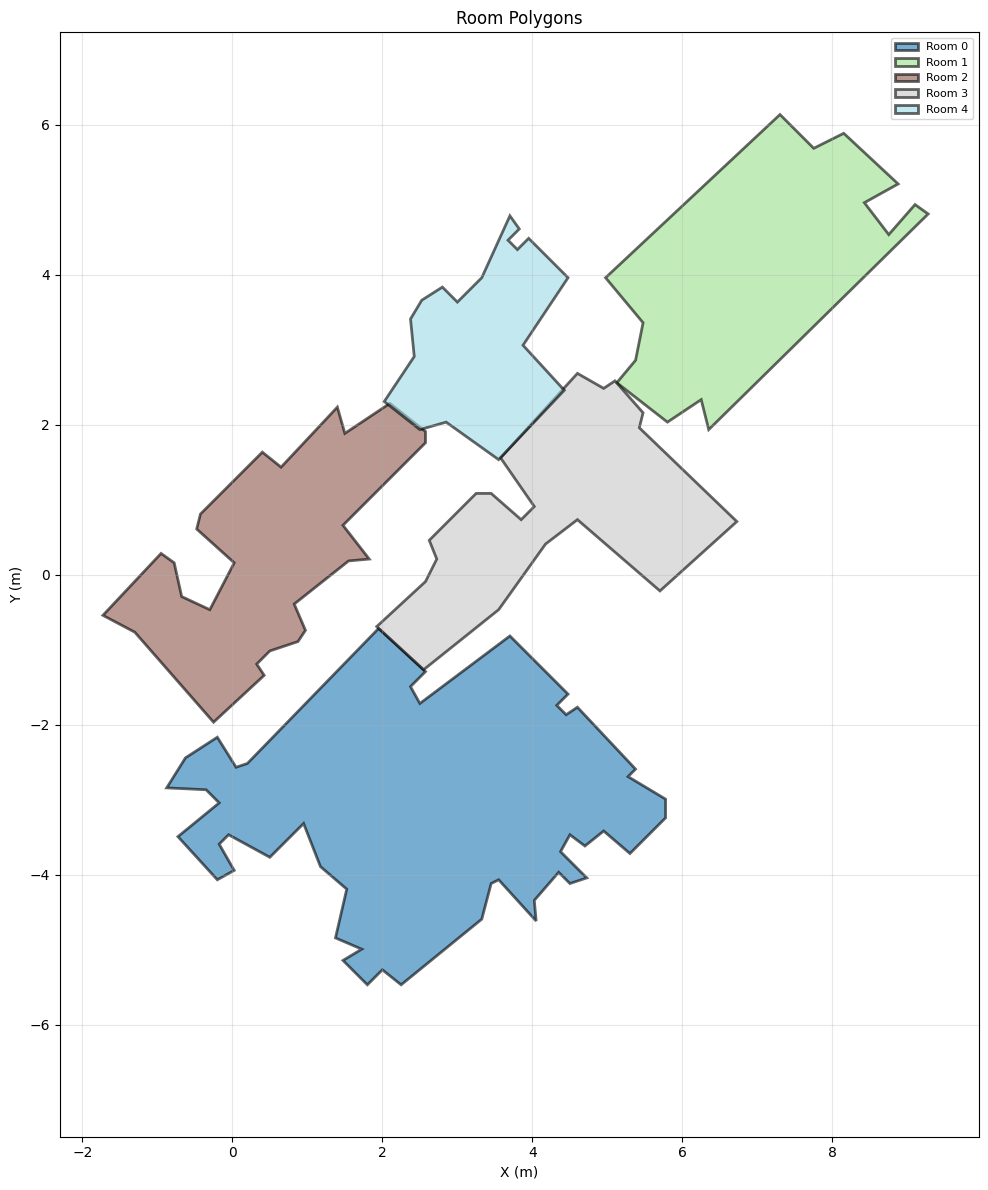

In [95]:
separator = run_room_separation_pipeline(
    floor_points,            # Your floor points
    vertical_points,             # Your wall points (from merged regions)
    grid_resolution=0.05,    # 5cm grid cells
    wall_distance_threshold=0.15,  # 15cm from walls for boundary
    n_rooms='auto',          # Auto-detect number of rooms
    min_room_area=2.0,       # Minimum 2m² per room
    show_occupancy=True,     # Show occupancy grid
    show_segmentation=True,  # Show room labels
    show_polygons=True,       # Show final polygons
   
)

In [75]:
class GraphRoomSeparator:
    """
    Separate rooms using graph-based segmentation with wall constraints
    """
    
    def __init__(self,
                 mode='wall_based',
                 grid_resolution=0.05,
                 wall_distance_threshold=0.15,
                 n_rooms='auto',
                 min_room_area=2.0,
                 verbose=True):
        """
        Parameters:
        -----------
        mode : str
            'wall_based' or 'floor_based'
            - wall_based: Create occupancy from walls only (flood fill interior)
            - floor_based: Use actual floor points
        grid_resolution : float
            Size of grid cells (meters)
        wall_distance_threshold : float
            Distance from walls to consider as boundary (meters)
        n_rooms : int or 'auto'
            Number of rooms to segment (auto = estimate from connectivity)
        min_room_area : float
            Minimum room area in square meters
        verbose : bool
            Print progress
        """
        self.mode = mode
        self.grid_resolution = grid_resolution
        self.wall_distance_threshold = wall_distance_threshold
        self.n_rooms = n_rooms
        self.min_room_area = min_room_area
        self.verbose = verbose
        
        # Results
        self.occupancy_grid = None
        self.wall_distance_grid = None
        self.room_labels_grid = None
        self.room_polygons = []
        self.grid_bounds = None
        
    
    def create_occupancy_grid(self, floor_points, wall_points):
        """
        Create 2D occupancy grid from wall points (and optionally floor points)
        
        Parameters:
        -----------
        floor_points : np.ndarray, shape (N, 3) or None
            Floor point coordinates (only for floor_based mode)
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        occupancy_grid : np.ndarray, shape (H, W)
            1 = floor (walkable), 0 = wall/empty
        grid_bounds : dict
            Grid coordinate bounds
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"CREATING OCCUPANCY GRID")
            print(f"{'='*70}")
            print(f"Mode: {self.mode}")
        
        # Get 2D coordinates (X, Y)
        wall_2d = wall_points[:, :2]
        
        # Compute grid bounds from wall points
        min_x, min_y = wall_2d.min(axis=0)
        max_x, max_y = wall_2d.max(axis=0)
        
        # Add padding
        padding = 0.5  # 50cm padding
        min_x -= padding
        min_y -= padding
        max_x += padding
        max_y += padding
        
        # Compute grid dimensions
        width = int(np.ceil((max_x - min_x) / self.grid_resolution))
        height = int(np.ceil((max_y - min_y) / self.grid_resolution))
        
        self.grid_bounds = {
            'min_x': min_x,
            'min_y': min_y,
            'max_x': max_x,
            'max_y': max_y,
            'width': width,
            'height': height
        }
        
        if self.verbose:
            print(f"Grid resolution: {self.grid_resolution}m")
            print(f"Grid dimensions: {width} x {height} = {width*height:,} cells")
            print(f"Bounds: X=[{min_x:.2f}, {max_x:.2f}], Y=[{min_y:.2f}, {max_y:.2f}]")
        
        if self.mode == 'floor_based':
            # Traditional approach: use floor points
            if floor_points is None:
                raise ValueError("floor_based mode requires floor_points")
            
            # Initialize grid (0 = empty)
            occupancy_grid = np.zeros((height, width), dtype=np.uint8)
            
            # Rasterize floor points (mark as 1 = walkable)
            floor_2d = floor_points[:, :2]
            grid_x = ((floor_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
            grid_y = ((floor_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
            
            # Clip to grid bounds
            valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
            grid_x = grid_x[valid]
            grid_y = grid_y[valid]
            
            occupancy_grid[grid_y, grid_x] = 1
            
            # Rasterize wall points (mark as 0 = obstacle)
            grid_x = ((wall_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
            grid_y = ((wall_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
            
            valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
            grid_x = grid_x[valid]
            grid_y = grid_y[valid]
            
            occupancy_grid[grid_y, grid_x] = 0
            
        else:  # wall_based mode
            # Initialize grid (1 = potentially walkable)
            occupancy_grid = np.ones((height, width), dtype=np.uint8)
            
            # Rasterize wall points (mark as 0 = obstacle)
            grid_x = ((wall_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
            grid_y = ((wall_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
            
            valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
            grid_x = grid_x[valid]
            grid_y = grid_y[valid]
            
            occupancy_grid[grid_y, grid_x] = 0
            
            # Dilate walls slightly to ensure connectivity
            occupancy_grid = ndimage.binary_erosion(occupancy_grid, iterations=1).astype(np.uint8)
            occupancy_grid = ndimage.binary_dilation(occupancy_grid, iterations=1).astype(np.uint8)
            
            # Flood fill from exterior to mark outside as 0
            if self.verbose:
                print(f"Flood filling exterior...")
            
            # Use custom flood fill implementation
            filled = occupancy_grid.copy()
            
            # Mark exterior with flood fill
            from skimage.segmentation import flood_fill
            
            # Seed from all four edges
            # Top edge
            for x in range(width):
                if filled[0, x] == 1:
                    filled = flood_fill(filled, (0, x), 0, connectivity=1)
            
            # Bottom edge
            for x in range(width):
                if filled[height-1, x] == 1:
                    filled = flood_fill(filled, (height-1, x), 0, connectivity=1)
            
            # Left edge
            for y in range(height):
                if filled[y, 0] == 1:
                    filled = flood_fill(filled, (y, 0), 0, connectivity=1)
            
            # Right edge
            for y in range(height):
                if filled[y, width-1] == 1:
                    filled = flood_fill(filled, (y, width-1), 0, connectivity=1)
            
            occupancy_grid = filled.astype(np.uint8)
            
            if self.verbose:
                print(f"Exterior filled")
        
        # Apply morphological operations to clean up
        # Close small holes in floor
        occupancy_grid = ndimage.binary_closing(occupancy_grid, iterations=2).astype(np.uint8)
        
        # Remove small isolated regions
        occupancy_grid = ndimage.binary_opening(occupancy_grid, iterations=1).astype(np.uint8)
        
        n_floor_cells = np.sum(occupancy_grid)
        floor_area = n_floor_cells * (self.grid_resolution ** 2)
        
        if self.verbose:
            print(f"Floor cells: {n_floor_cells:,} ({100*n_floor_cells/(width*height):.1f}%)")
            print(f"Floor area: {floor_area:.2f} m²")
        
        self.occupancy_grid = occupancy_grid
        return occupancy_grid, self.grid_bounds
    
    
    def compute_wall_distance_field(self, wall_points):
        """
        Compute distance from each grid cell to nearest wall
        
        Parameters:
        -----------
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        distance_grid : np.ndarray, shape (H, W)
            Distance to nearest wall for each cell
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"COMPUTING WALL DISTANCE FIELD")
            print(f"{'='*70}")
        
        height, width = self.occupancy_grid.shape
        min_x = self.grid_bounds['min_x']
        min_y = self.grid_bounds['min_y']
        
        # Create grid of cell centers
        x_coords = np.arange(width) * self.grid_resolution + min_x + self.grid_resolution/2
        y_coords = np.arange(height) * self.grid_resolution + min_y + self.grid_resolution/2
        xx, yy = np.meshgrid(x_coords, y_coords)
        
        grid_points = np.column_stack([xx.ravel(), yy.ravel()])
        
        # Build KD-tree on wall points (2D)
        wall_2d = wall_points[:, :2]
        kdtree = KDTree(wall_2d)
        
        # Query nearest wall for each grid cell
        if self.verbose:
            print(f"Computing distances for {len(grid_points):,} grid cells...")
        
        distances, _ = kdtree.query(grid_points, k=1)
        distance_grid = distances.reshape(height, width)
        
        if self.verbose:
            print(f"Distance range: [{distance_grid.min():.3f}, {distance_grid.max():.3f}] meters")
        
        self.wall_distance_grid = distance_grid
        return distance_grid
    
    
    def build_graph(self):
        """
        Build graph from occupancy grid with wall-based edge weights
        
        Returns:
        --------
        adjacency_matrix : scipy.sparse matrix
            Weighted adjacency matrix
        node_indices : np.ndarray
            Mapping from (y, x) to graph node index
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"BUILDING CONNECTIVITY GRAPH")
            print(f"{'='*70}")
        
        height, width = self.occupancy_grid.shape
        
        # Create node index mapping (only for floor cells)
        node_indices = np.full((height, width), -1, dtype=int)
        floor_mask = self.occupancy_grid > 0
        n_nodes = np.sum(floor_mask)
        node_indices[floor_mask] = np.arange(n_nodes)
        
        if self.verbose:
            print(f"Graph nodes: {n_nodes:,}")
        
        # Build adjacency list
        rows = []
        cols = []
        weights = []
        
        # 4-connectivity (up, down, left, right)
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        for y in range(height):
            for x in range(width):
                if not floor_mask[y, x]:
                    continue
                
                node_i = node_indices[y, x]
                
                # Check each neighbor
                for dy, dx in neighbors:
                    ny, nx = y + dy, x + dx
                    
                    # Check bounds
                    if ny < 0 or ny >= height or nx < 0 or nx >= width:
                        continue
                    
                    # Check if neighbor is floor
                    if not floor_mask[ny, nx]:
                        continue
                    
                    node_j = node_indices[ny, nx]
                    
                    # Compute edge weight based on wall proximity
                    # Higher weight = stronger connection = less likely to cut
                    # Lower weight = weaker connection = more likely to cut
                    
                    # Average distance to walls for both cells
                    dist_i = self.wall_distance_grid[y, x]
                    dist_j = self.wall_distance_grid[ny, nx]
                    avg_dist = (dist_i + dist_j) / 2
                    
                    # Weight function:
                    # - Far from walls (open space): high weight (don't cut)
                    # - Near walls (doorways): low weight (easy to cut)
                    # - Very close to walls: medium weight (boundary cells)
                    
                    if avg_dist > self.wall_distance_threshold:
                        # Open space - strong connection
                        weight = 1.0
                    else:
                        # Near walls - connection strength decreases with proximity
                        # At wall: weight ≈ 0.1
                        # At threshold: weight ≈ 1.0
                        weight = (avg_dist / self.wall_distance_threshold) ** 2
                        weight = max(0.1, weight)  # Minimum weight
                    
                    rows.append(node_i)
                    cols.append(node_j)
                    weights.append(weight)
        
        # Create sparse adjacency matrix
        adjacency_matrix = csr_matrix(
            (weights, (rows, cols)),
            shape=(n_nodes, n_nodes)
        )
        
        # Make symmetric
        adjacency_matrix = adjacency_matrix + adjacency_matrix.T
        
        if self.verbose:
            print(f"Graph edges: {len(weights):,}")
            print(f"Average degree: {2*len(weights)/n_nodes:.1f}")
        
        return adjacency_matrix, node_indices
    
    
    def estimate_n_rooms(self, adjacency_matrix):
        """
        Estimate number of rooms from graph connectivity
        """
        
        # Find connected components (rooms separated by walls with no doors)
        n_components, labels = connected_components(
            adjacency_matrix, 
            directed=False,
            return_labels=True
        )
        
        if self.verbose:
            print(f"\nEstimated {n_components} connected components")
        
        # Use 2-3x connected components as estimate (accounts for rooms with doors)
        estimated_rooms = max(3, min(15, n_components * 2))
        
        return estimated_rooms
    
    
    def segment_rooms(self, adjacency_matrix, node_indices):
        """
        Segment rooms using spectral clustering
        
        Parameters:
        -----------
        adjacency_matrix : scipy.sparse matrix
            Graph adjacency matrix
        node_indices : np.ndarray
            Node index mapping
        
        Returns:
        --------
        room_labels_grid : np.ndarray, shape (H, W)
            Room label for each grid cell (-1 = wall/empty)
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"SEGMENTING ROOMS")
            print(f"{'='*70}")
        
        # Determine number of rooms
        if self.n_rooms == 'auto':
            n_rooms = self.estimate_n_rooms(adjacency_matrix)
            if self.verbose:
                print(f"Auto-detected n_rooms: {n_rooms}")
        else:
            n_rooms = self.n_rooms
        
        # Apply spectral clustering
        if self.verbose:
            print(f"Running spectral clustering with {n_rooms} clusters...")
        
        clustering = SpectralClustering(
            n_clusters=n_rooms,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42,
            n_init=10
        )
        
        node_labels = clustering.fit_predict(adjacency_matrix)
        
        # Map back to grid
        height, width = self.occupancy_grid.shape
        room_labels_grid = np.full((height, width), -1, dtype=int)
        
        floor_mask = self.occupancy_grid > 0
        room_labels_grid[floor_mask] = node_labels
        
        # Filter small regions
        for room_id in range(n_rooms):
            mask = room_labels_grid == room_id
            area = np.sum(mask) * (self.grid_resolution ** 2)
            
            if area < self.min_room_area:
                if self.verbose:
                    print(f"  Filtering room {room_id} (area={area:.2f}m² < {self.min_room_area}m²)")
                room_labels_grid[mask] = -1
        
        # Renumber rooms
        unique_rooms = np.unique(room_labels_grid)
        unique_rooms = unique_rooms[unique_rooms >= 0]
        
        new_room_labels = np.full_like(room_labels_grid, -1)
        for new_id, old_id in enumerate(unique_rooms):
            new_room_labels[room_labels_grid == old_id] = new_id
        
        room_labels_grid = new_room_labels
        n_final_rooms = len(unique_rooms)
        
        if self.verbose:
            print(f"\nFinal rooms: {n_final_rooms}")
            for room_id in range(n_final_rooms):
                mask = room_labels_grid == room_id
                area = np.sum(mask) * (self.grid_resolution ** 2)
                print(f"  Room {room_id}: {area:.2f} m²")
        
        self.room_labels_grid = room_labels_grid
        return room_labels_grid
    
    
    def extract_room_polygons(self):
        """
        Extract polygon boundaries for each room
        
        Returns:
        --------
        room_polygons : list of shapely.Polygon
            Polygon for each room
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"EXTRACTING ROOM POLYGONS")
            print(f"{'='*70}")
        
        height, width = self.room_labels_grid.shape
        min_x = self.grid_bounds['min_x']
        min_y = self.grid_bounds['min_y']
        
        unique_rooms = np.unique(self.room_labels_grid)
        unique_rooms = unique_rooms[unique_rooms >= 0]
        
        room_polygons = []
        
        for room_id in unique_rooms:
            # Get room mask
            mask = (self.room_labels_grid == room_id).astype(np.uint8)
            
            # Find contours using connected components
            from skimage import measure
            contours = measure.find_contours(mask, 0.5)
            
            if len(contours) == 0:
                continue
            
            # Convert largest contour to polygon
            contour = max(contours, key=len)
            
            # Convert grid coordinates to world coordinates
            coords = []
            for point in contour:
                y, x = point
                world_x = x * self.grid_resolution + min_x
                world_y = y * self.grid_resolution + min_y
                coords.append([world_x, world_y])
            
            # Create polygon
            if len(coords) >= 3:
                poly = Polygon(coords)
                
                # Simplify polygon
                poly = poly.simplify(self.grid_resolution * 2, preserve_topology=True)
                
                if poly.is_valid and poly.area > 0:
                    room_polygons.append(poly)
                    
                    if self.verbose:
                        print(f"  Room {room_id}: {poly.area:.2f} m², {len(poly.exterior.coords)} vertices")
        
        self.room_polygons = room_polygons
        return room_polygons
    
    
    def fit(self, floor_points, wall_points):
        """
        Complete room separation pipeline
        
        Parameters:
        -----------
        floor_points : np.ndarray, shape (N, 3)
            Floor point coordinates
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        self
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"GRAPH-BASED ROOM SEPARATION PIPELINE")
            print(f"{'='*70}")
        
        start_time = time.time()
        
        # Step 1: Create occupancy grid
        self.create_occupancy_grid(floor_points, wall_points)
        
        # Step 2: Compute wall distance field
        self.compute_wall_distance_field(wall_points)
        
        # Step 3: Build graph
        adjacency_matrix, node_indices = self.build_graph()
        
        # Step 4: Segment rooms
        self.segment_rooms(adjacency_matrix, node_indices)
        
        # Step 5: Extract polygons
        self.extract_room_polygons()
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"Pipeline completed in {elapsed:.2f}s")
            print(f"Total rooms: {len(self.room_polygons)}")
            print(f"{'='*70}")
        
        return self


def visualize_occupancy_grid(occupancy_grid, grid_bounds, title="Occupancy Grid"):
    """Visualize occupancy grid"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    extent = [
        grid_bounds['min_x'],
        grid_bounds['max_x'],
        grid_bounds['min_y'],
        grid_bounds['max_y']
    ]
    
    ax.imshow(occupancy_grid, origin='lower', extent=extent, cmap='gray', alpha=0.8)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def visualize_room_segmentation(room_labels_grid, grid_bounds, title="Room Segmentation"):
    """Visualize room labels"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    extent = [
        grid_bounds['min_x'],
        grid_bounds['max_x'],
        grid_bounds['min_y'],
        grid_bounds['max_y']
    ]
    
    # Create color map
    masked_labels = np.ma.masked_where(room_labels_grid == -1, room_labels_grid)
    
    im = ax.imshow(masked_labels, origin='lower', extent=extent, 
                   cmap='tab20', alpha=0.8, interpolation='nearest')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Room ID')
    
    plt.tight_layout()
    return fig


def visualize_room_polygons(room_polygons, grid_bounds, title="Room Polygons"):
    """Visualize room polygons"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(room_polygons)))
    
    for i, poly in enumerate(room_polygons):
        if poly.exterior is None:
            continue
            
        coords = np.array(poly.exterior.coords)
        patch = MplPolygon(coords, facecolor=colors[i], edgecolor='black', 
                          linewidth=2, alpha=0.6, label=f'Room {i}')
        ax.add_patch(patch)
    
    ax.set_xlim(grid_bounds['min_x'], grid_bounds['max_x'])
    ax.set_ylim(grid_bounds['min_y'], grid_bounds['max_y'])
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if len(room_polygons) <= 15:
        ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    return fig


def run_room_separation_pipeline(wall_points,
                                 floor_points=None,
                                 mode='wall_based',
                                 grid_resolution=0.05,
                                 wall_distance_threshold=0.15,
                                 n_rooms='auto',
                                 min_room_area=2.0,
                                 show_occupancy=True,
                                 show_segmentation=True,
                                 show_polygons=True):
    """
    Complete room separation pipeline with visualization
    
    Parameters:
    -----------
    wall_points : np.ndarray, shape (M, 3)
        Wall point coordinates (REQUIRED)
    floor_points : np.ndarray, shape (N, 3) or None
        Floor point coordinates (only needed for 'floor_based' mode)
    mode : str
        'wall_based' or 'floor_based'
        - wall_based: Create occupancy from walls only (recommended)
        - floor_based: Use actual floor points
    grid_resolution : float
        Grid cell size (meters)
    wall_distance_threshold : float
        Distance from walls for boundary detection (meters)
    n_rooms : int or 'auto'
        Number of rooms to segment
    min_room_area : float
        Minimum room area (m²)
    show_occupancy : bool
        Show occupancy grid
    show_segmentation : bool
        Show room segmentation
    show_polygons : bool
        Show room polygons
    
    Returns:
    --------
    separator : GraphRoomSeparator
        Fitted separator with results
    """
    
    # Validate inputs
    if mode == 'floor_based' and floor_points is None:
        raise ValueError("floor_based mode requires floor_points to be provided")
    
    # Create and fit separator
    separator = GraphRoomSeparator(
        mode=mode,
        grid_resolution=grid_resolution,
        wall_distance_threshold=wall_distance_threshold,
        n_rooms=n_rooms,
        min_room_area=min_room_area,
        verbose=True
    )
    
    separator.fit(floor_points, wall_points)
    
    # Visualizations
    if show_occupancy:
        fig_occ = visualize_occupancy_grid(
            separator.occupancy_grid,
            separator.grid_bounds
        )
        plt.show()
    
    if show_segmentation:
        fig_seg = visualize_room_segmentation(
            separator.room_labels_grid,
            separator.grid_bounds
        )
        plt.show()
    
    if show_polygons:
        fig_poly = visualize_room_polygons(
            separator.room_polygons,
            separator.grid_bounds
        )
        plt.show()
    
    return separator


GRAPH-BASED ROOM SEPARATION PIPELINE

CREATING OCCUPANCY GRID
Mode: wall_based
Grid resolution: 0.05m
Grid dimensions: 245 x 295 = 72,275 cells
Bounds: X=[-2.30, 9.95], Y=[-7.49, 7.23]
Flood filling exterior...
Exterior filled
Floor cells: 18,339 (25.4%)
Floor area: 45.85 m²

COMPUTING WALL DISTANCE FIELD
Computing distances for 72,275 grid cells...
Distance range: [0.000, 5.767] meters

BUILDING CONNECTIVITY GRAPH
Graph nodes: 18,339
Graph edges: 70,408
Average degree: 7.7

SEGMENTING ROOMS
Running spectral clustering with 8 clusters...


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  Filtering room 1 (area=0.01m² < 1.0m²)
  Filtering room 2 (area=0.01m² < 1.0m²)
  Filtering room 3 (area=0.01m² < 1.0m²)
  Filtering room 4 (area=0.06m² < 1.0m²)
  Filtering room 5 (area=0.06m² < 1.0m²)
  Filtering room 6 (area=0.02m² < 1.0m²)
  Filtering room 7 (area=0.89m² < 1.0m²)

Final rooms: 1
  Room 0: 44.80 m²

EXTRACTING ROOM POLYGONS
  Room 0: 23.89 m², 39 vertices

Pipeline completed in 6.36s
Total rooms: 1


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


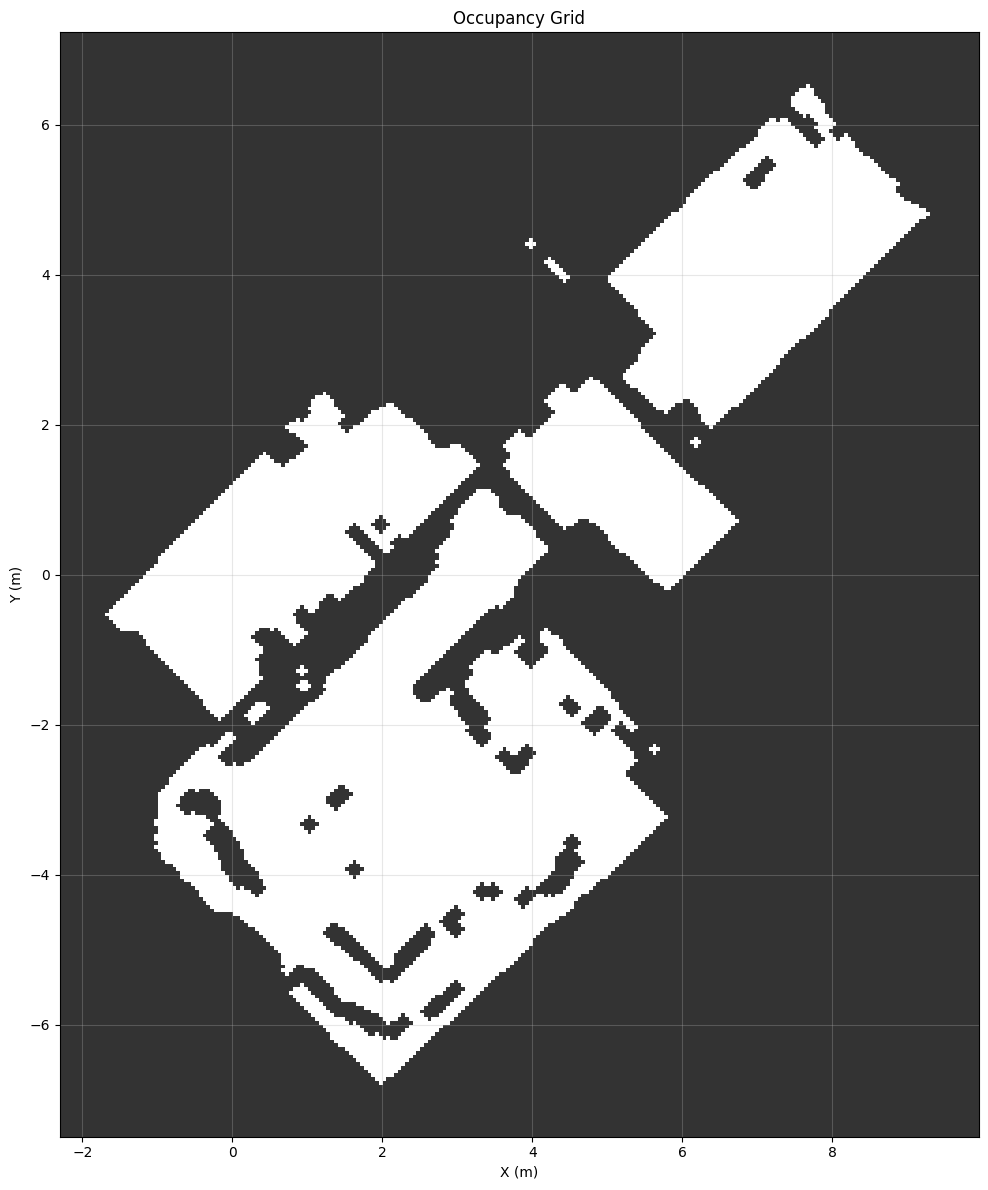

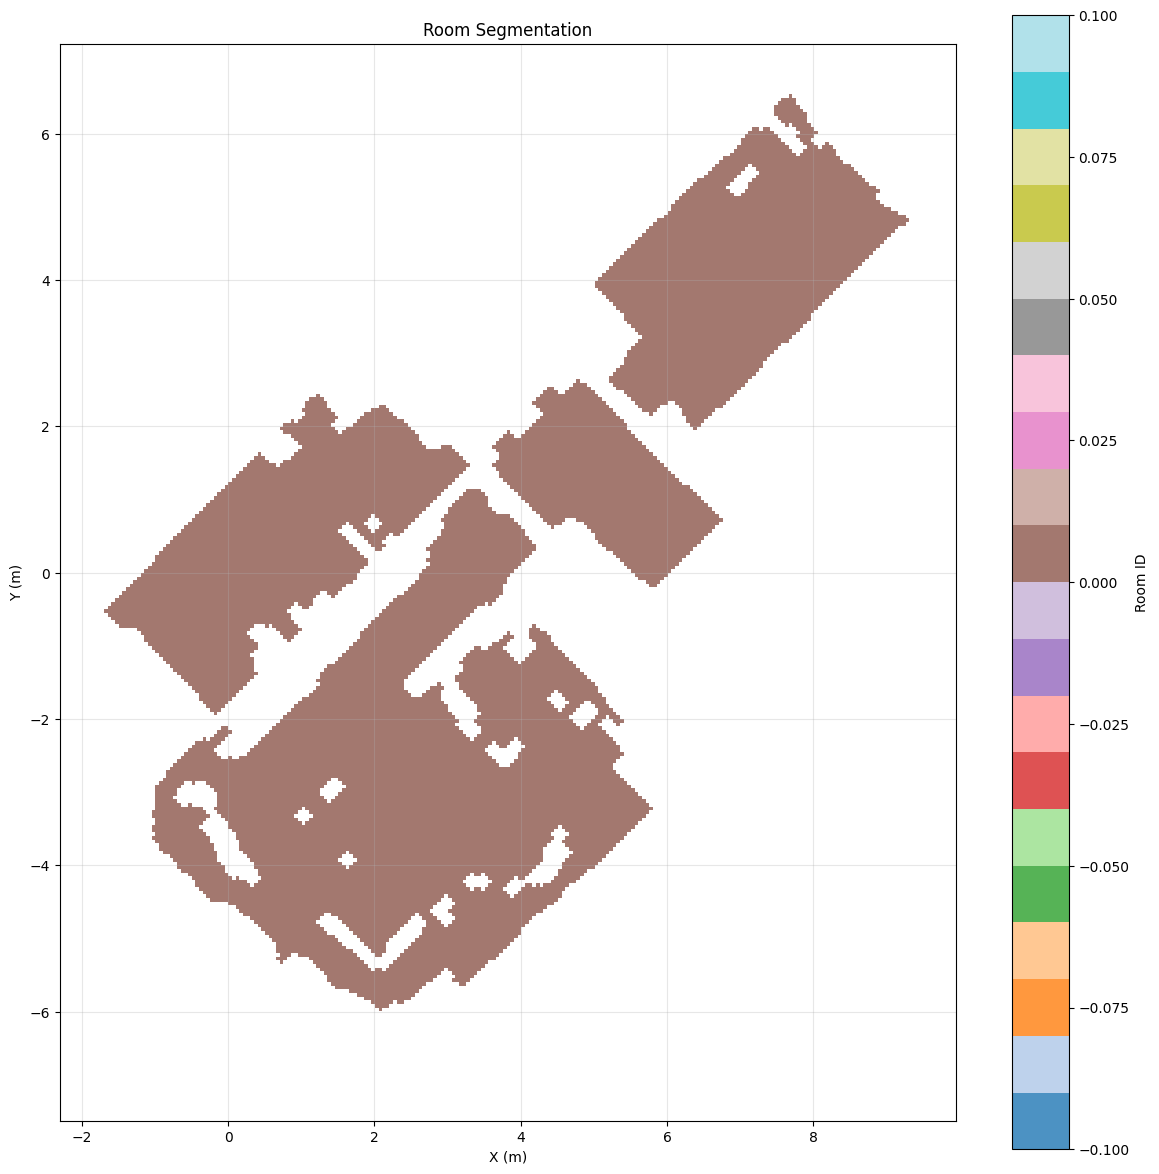

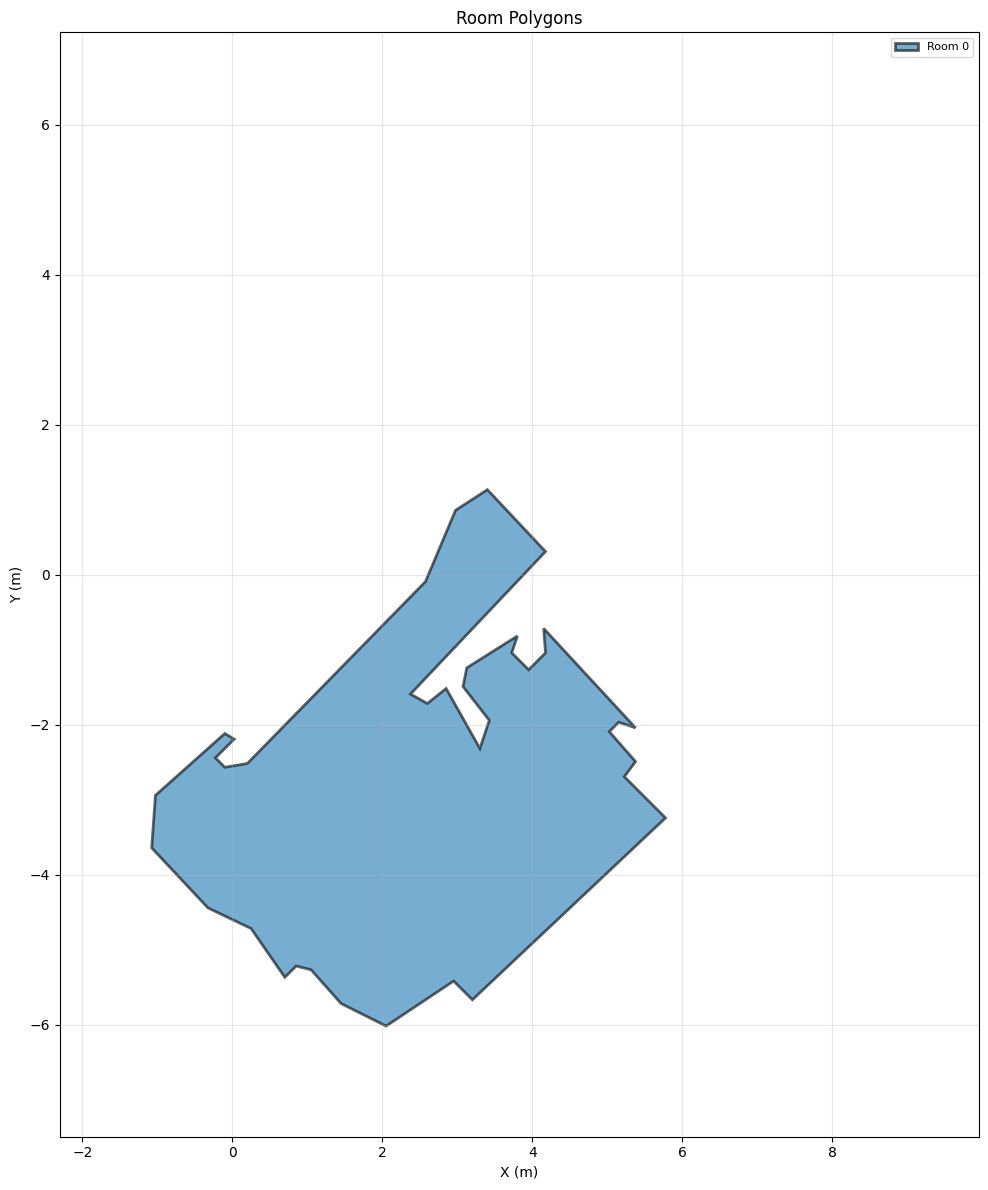

In [79]:
separator = run_room_separation_pipeline(
    vertical_points,                     # Your 46 wall regions
    mode='wall_based',               # Wall-based mode
    grid_resolution=0.05,            # 5cm cells
    wall_distance_threshold=0.15,    # 15cm from walls
    n_rooms=8,                  # Auto-detect rooms
    min_room_area=1.0,               # Min 2m² per room
    show_occupancy=True,
    show_segmentation=True,
    show_polygons=True
)

In [85]:
class GraphRoomSeparator:
    """
    Separate rooms using graph-based segmentation with wall constraints
    """
    
    def __init__(self,
                 mode='wall_based',
                 grid_resolution=0.05,
                 wall_distance_threshold=0.15,
                 n_rooms='auto',
                 min_room_area=2.0,
                 close_doors=True,
                 door_closing_iterations=3,
                 verbose=True):
        """
        Parameters:
        -----------
        mode : str
            'wall_based' or 'floor_based'
            - wall_based: Create occupancy from walls only (flood fill interior)
            - floor_based: Use actual floor points
        grid_resolution : float
            Size of grid cells (meters)
        wall_distance_threshold : float
            Distance from walls to consider as boundary (meters)
        n_rooms : int or 'auto'
            Number of rooms to segment (auto = estimate from connectivity)
        min_room_area : float
            Minimum room area in square meters
        close_doors : bool
            Close doorways by dilating walls before segmentation
        door_closing_iterations : int
            Number of dilation iterations to close doors (higher = close larger gaps)
        verbose : bool
            Print progress
        """
        self.mode = mode
        self.grid_resolution = grid_resolution
        self.wall_distance_threshold = wall_distance_threshold
        self.n_rooms = n_rooms
        self.min_room_area = min_room_area
        self.close_doors = close_doors
        self.door_closing_iterations = door_closing_iterations
        self.verbose = verbose
        
        # Results
        self.occupancy_grid = None
        self.wall_distance_grid = None
        self.room_labels_grid = None
        self.room_polygons = []
        self.grid_bounds = None
        
    
    def create_occupancy_grid(self, floor_points, wall_points):
        """
        Create 2D occupancy grid from wall points (and optionally floor points)
        
        Parameters:
        -----------
        floor_points : np.ndarray, shape (N, 3) or None
            Floor point coordinates (only for floor_based mode)
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        occupancy_grid : np.ndarray, shape (H, W)
            1 = floor (walkable), 0 = wall/empty
        grid_bounds : dict
            Grid coordinate bounds
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"CREATING OCCUPANCY GRID")
            print(f"{'='*70}")
            print(f"Mode: {self.mode}")
        
        # Get 2D coordinates (X, Y)
        wall_2d = wall_points[:, :2]
        
        # Compute grid bounds from wall points
        min_x, min_y = wall_2d.min(axis=0)
        max_x, max_y = wall_2d.max(axis=0)
        
        # Add padding
        padding = 0.5  # 50cm padding
        min_x -= padding
        min_y -= padding
        max_x += padding
        max_y += padding
        
        # Compute grid dimensions
        width = int(np.ceil((max_x - min_x) / self.grid_resolution))
        height = int(np.ceil((max_y - min_y) / self.grid_resolution))
        
        self.grid_bounds = {
            'min_x': min_x,
            'min_y': min_y,
            'max_x': max_x,
            'max_y': max_y,
            'width': width,
            'height': height
        }
        
        if self.verbose:
            print(f"Grid resolution: {self.grid_resolution}m")
            print(f"Grid dimensions: {width} x {height} = {width*height:,} cells")
            print(f"Bounds: X=[{min_x:.2f}, {max_x:.2f}], Y=[{min_y:.2f}, {max_y:.2f}]")
        
        if self.mode == 'floor_based':
            # Traditional approach: use floor points
            if floor_points is None:
                raise ValueError("floor_based mode requires floor_points")
            
            # Initialize grid (0 = empty)
            occupancy_grid = np.zeros((height, width), dtype=np.uint8)
            
            # Rasterize floor points (mark as 1 = walkable)
            floor_2d = floor_points[:, :2]
            grid_x = ((floor_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
            grid_y = ((floor_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
            
            # Clip to grid bounds
            valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
            grid_x = grid_x[valid]
            grid_y = grid_y[valid]
            
            occupancy_grid[grid_y, grid_x] = 1
            
            # Rasterize wall points (mark as 0 = obstacle)
            grid_x = ((wall_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
            grid_y = ((wall_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
            
            valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
            grid_x = grid_x[valid]
            grid_y = grid_y[valid]
            
            occupancy_grid[grid_y, grid_x] = 0
            
        else:  # wall_based mode
            # Initialize grid (1 = potentially walkable)
            occupancy_grid = np.ones((height, width), dtype=np.uint8)
            
            # Rasterize wall points (mark as 0 = obstacle)
            grid_x = ((wall_2d[:, 0] - min_x) / self.grid_resolution).astype(int)
            grid_y = ((wall_2d[:, 1] - min_y) / self.grid_resolution).astype(int)
            
            valid = (grid_x >= 0) & (grid_x < width) & (grid_y >= 0) & (grid_y < height)
            grid_x = grid_x[valid]
            grid_y = grid_y[valid]
            
            occupancy_grid[grid_y, grid_x] = 0
            
            # Dilate walls slightly to ensure connectivity
            occupancy_grid = ndimage.binary_erosion(occupancy_grid, iterations=1).astype(np.uint8)
            occupancy_grid = ndimage.binary_dilation(occupancy_grid, iterations=1).astype(np.uint8)
            
            # Flood fill from exterior to mark outside as 0
            if self.verbose:
                print(f"Flood filling exterior...")
            
            # Use custom flood fill implementation
            filled = occupancy_grid.copy()
            
            # Mark exterior with flood fill
            from skimage.segmentation import flood_fill
            
            # Seed from all four edges
            # Top edge
            for x in range(width):
                if filled[0, x] == 1:
                    filled = flood_fill(filled, (0, x), 0, connectivity=1)
            
            # Bottom edge
            for x in range(width):
                if filled[height-1, x] == 1:
                    filled = flood_fill(filled, (height-1, x), 0, connectivity=1)
            
            # Left edge
            for y in range(height):
                if filled[y, 0] == 1:
                    filled = flood_fill(filled, (y, 0), 0, connectivity=1)
            
            # Right edge
            for y in range(height):
                if filled[y, width-1] == 1:
                    filled = flood_fill(filled, (y, width-1), 0, connectivity=1)
            
            occupancy_grid = filled.astype(np.uint8)
            
            if self.verbose:
                print(f"Exterior filled")
        
        # Apply morphological operations to clean up
        # Close small holes in floor
        occupancy_grid = ndimage.binary_closing(occupancy_grid, iterations=2).astype(np.uint8)
        
        # Remove small isolated regions
        occupancy_grid = ndimage.binary_opening(occupancy_grid, iterations=1).astype(np.uint8)
        
        # Store original occupancy grid (with doors open)
        self.occupancy_grid_original = occupancy_grid.copy()
        
        # Optionally close doors for better room separation
        if self.close_doors:
            if self.verbose:
                print(f"Closing doors (dilating walls {self.door_closing_iterations} iterations)...")
            
            # Invert: 1=wall, 0=floor
            walls = 1 - occupancy_grid
            
            # Dilate walls to close doorways
            walls_dilated = ndimage.binary_dilation(walls, iterations=self.door_closing_iterations)
            
            # Convert back: 0=wall, 1=floor
            occupancy_grid = (1 - walls_dilated).astype(np.uint8)
            
            if self.verbose:
                n_closed_cells = np.sum(self.occupancy_grid_original) - np.sum(occupancy_grid)
                print(f"Closed {n_closed_cells:,} doorway cells")
        
        n_floor_cells = np.sum(occupancy_grid)
        floor_area = n_floor_cells * (self.grid_resolution ** 2)
        
        if self.verbose:
            print(f"Floor cells: {n_floor_cells:,} ({100*n_floor_cells/(width*height):.1f}%)")
            print(f"Floor area: {floor_area:.2f} m²")
        
        self.occupancy_grid = occupancy_grid
        return occupancy_grid, self.grid_bounds
    
    
    def compute_wall_distance_field(self, wall_points):
        """
        Compute distance from each grid cell to nearest wall
        
        Parameters:
        -----------
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        distance_grid : np.ndarray, shape (H, W)
            Distance to nearest wall for each cell
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"COMPUTING WALL DISTANCE FIELD")
            print(f"{'='*70}")
        
        height, width = self.occupancy_grid.shape
        min_x = self.grid_bounds['min_x']
        min_y = self.grid_bounds['min_y']
        
        # Create grid of cell centers
        x_coords = np.arange(width) * self.grid_resolution + min_x + self.grid_resolution/2
        y_coords = np.arange(height) * self.grid_resolution + min_y + self.grid_resolution/2
        xx, yy = np.meshgrid(x_coords, y_coords)
        
        grid_points = np.column_stack([xx.ravel(), yy.ravel()])
        
        # Build KD-tree on wall points (2D)
        wall_2d = wall_points[:, :2]
        kdtree = KDTree(wall_2d)
        
        # Query nearest wall for each grid cell
        if self.verbose:
            print(f"Computing distances for {len(grid_points):,} grid cells...")
        
        distances, _ = kdtree.query(grid_points, k=1)
        distance_grid = distances.reshape(height, width)
        
        if self.verbose:
            print(f"Distance range: [{distance_grid.min():.3f}, {distance_grid.max():.3f}] meters")
        
        self.wall_distance_grid = distance_grid
        return distance_grid
    
    
    def build_graph(self):
        """
        Build graph from occupancy grid with wall-based edge weights
        
        Returns:
        --------
        adjacency_matrix : scipy.sparse matrix
            Weighted adjacency matrix
        node_indices : np.ndarray
            Mapping from (y, x) to graph node index
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"BUILDING CONNECTIVITY GRAPH")
            print(f"{'='*70}")
        
        height, width = self.occupancy_grid.shape
        
        # Create node index mapping (only for floor cells)
        node_indices = np.full((height, width), -1, dtype=int)
        floor_mask = self.occupancy_grid > 0
        n_nodes = np.sum(floor_mask)
        node_indices[floor_mask] = np.arange(n_nodes)
        
        if self.verbose:
            print(f"Graph nodes: {n_nodes:,}")
        
        # Build adjacency list
        rows = []
        cols = []
        weights = []
        
        # 4-connectivity (up, down, left, right)
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
        for y in range(height):
            for x in range(width):
                if not floor_mask[y, x]:
                    continue
                
                node_i = node_indices[y, x]
                
                # Check each neighbor
                for dy, dx in neighbors:
                    ny, nx = y + dy, x + dx
                    
                    # Check bounds
                    if ny < 0 or ny >= height or nx < 0 or nx >= width:
                        continue
                    
                    # Check if neighbor is floor
                    if not floor_mask[ny, nx]:
                        continue
                    
                    node_j = node_indices[ny, nx]
                    
                    # Compute edge weight based on wall proximity
                    # Higher weight = stronger connection = less likely to cut
                    # Lower weight = weaker connection = more likely to cut
                    
                    # Average distance to walls for both cells
                    dist_i = self.wall_distance_grid[y, x]
                    dist_j = self.wall_distance_grid[ny, nx]
                    avg_dist = (dist_i + dist_j) / 2
                    
                    # Weight function:
                    # - Far from walls (open space): high weight (don't cut)
                    # - Near walls (doorways): low weight (easy to cut)
                    # - Very close to walls: medium weight (boundary cells)
                    
                    if avg_dist > self.wall_distance_threshold:
                        # Open space - strong connection
                        weight = 1.0
                    else:
                        # Near walls - connection strength decreases with proximity
                        # At wall: weight ≈ 0.1
                        # At threshold: weight ≈ 1.0
                        weight = (avg_dist / self.wall_distance_threshold) ** 2
                        weight = max(0.1, weight)  # Minimum weight
                    
                    rows.append(node_i)
                    cols.append(node_j)
                    weights.append(weight)
        
        # Create sparse adjacency matrix
        adjacency_matrix = csr_matrix(
            (weights, (rows, cols)),
            shape=(n_nodes, n_nodes)
        )
        
        # Make symmetric
        adjacency_matrix = adjacency_matrix + adjacency_matrix.T
        
        if self.verbose:
            print(f"Graph edges: {len(weights):,}")
            print(f"Average degree: {2*len(weights)/n_nodes:.1f}")
        
        return adjacency_matrix, node_indices
    
    
    def estimate_n_rooms(self, adjacency_matrix):
        """
        Estimate number of rooms from graph connectivity
        """
        
        # Find connected components (rooms separated by walls with no doors)
        n_components, labels = connected_components(
            adjacency_matrix, 
            directed=False,
            return_labels=True
        )
        
        if self.verbose:
            print(f"\nEstimated {n_components} connected components")
        
        # Use 2-3x connected components as estimate (accounts for rooms with doors)
        estimated_rooms = max(3, min(15, n_components * 2))
        
        return estimated_rooms
    
    
    def segment_rooms(self, adjacency_matrix, node_indices):
        """
        Segment rooms using spectral clustering
        
        Parameters:
        -----------
        adjacency_matrix : scipy.sparse matrix
            Graph adjacency matrix
        node_indices : np.ndarray
            Node index mapping
        
        Returns:
        --------
        room_labels_grid : np.ndarray, shape (H, W)
            Room label for each grid cell (-1 = wall/empty)
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"SEGMENTING ROOMS")
            print(f"{'='*70}")
        
        # Determine number of rooms
        if self.n_rooms == 'auto':
            n_rooms = self.estimate_n_rooms(adjacency_matrix)
            if self.verbose:
                print(f"Auto-detected n_rooms: {n_rooms}")
        else:
            n_rooms = self.n_rooms
        
        # Apply spectral clustering
        if self.verbose:
            print(f"Running spectral clustering with {n_rooms} clusters...")
        
        clustering = SpectralClustering(
            n_clusters=n_rooms,
            affinity='precomputed',
            assign_labels='kmeans',
            random_state=42,
            n_init=10
        )
        
        node_labels = clustering.fit_predict(adjacency_matrix)
        
        # Map back to grid
        height, width = self.occupancy_grid.shape
        room_labels_grid = np.full((height, width), -1, dtype=int)
        
        floor_mask = self.occupancy_grid > 0
        room_labels_grid[floor_mask] = node_labels
        
        # Filter small regions
        for room_id in range(n_rooms):
            mask = room_labels_grid == room_id
            area = np.sum(mask) * (self.grid_resolution ** 2)
            
            if area < self.min_room_area:
                if self.verbose:
                    print(f"  Filtering room {room_id} (area={area:.2f}m² < {self.min_room_area}m²)")
                room_labels_grid[mask] = -1
        
        # Renumber rooms
        unique_rooms = np.unique(room_labels_grid)
        unique_rooms = unique_rooms[unique_rooms >= 0]
        
        new_room_labels = np.full_like(room_labels_grid, -1)
        for new_id, old_id in enumerate(unique_rooms):
            new_room_labels[room_labels_grid == old_id] = new_id
        
        room_labels_grid = new_room_labels
        n_final_rooms = len(unique_rooms)
        
        if self.verbose:
            print(f"\nFinal rooms: {n_final_rooms}")
            for room_id in range(n_final_rooms):
                mask = room_labels_grid == room_id
                area = np.sum(mask) * (self.grid_resolution ** 2)
                print(f"  Room {room_id}: {area:.2f} m²")
        
        self.room_labels_grid = room_labels_grid
        return room_labels_grid
    
    
    def extract_room_polygons(self):
        """
        Extract polygon boundaries for each room
        
        Returns:
        --------
        room_polygons : list of shapely.Polygon
            Polygon for each room
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"EXTRACTING ROOM POLYGONS")
            print(f"{'='*70}")
        
        height, width = self.room_labels_grid.shape
        min_x = self.grid_bounds['min_x']
        min_y = self.grid_bounds['min_y']
        
        unique_rooms = np.unique(self.room_labels_grid)
        unique_rooms = unique_rooms[unique_rooms >= 0]
        
        room_polygons = []
        
        for room_id in unique_rooms:
            # Get room mask
            mask = (self.room_labels_grid == room_id).astype(np.uint8)
            
            # Find contours using connected components
            from skimage import measure
            contours = measure.find_contours(mask, 0.5)
            
            if len(contours) == 0:
                continue
            
            # Convert largest contour to polygon
            contour = max(contours, key=len)
            
            # Convert grid coordinates to world coordinates
            coords = []
            for point in contour:
                y, x = point
                world_x = x * self.grid_resolution + min_x
                world_y = y * self.grid_resolution + min_y
                coords.append([world_x, world_y])
            
            # Create polygon
            if len(coords) >= 3:
                poly = Polygon(coords)
                
                # Simplify polygon
                poly = poly.simplify(self.grid_resolution * 2, preserve_topology=True)
                
                if poly.is_valid and poly.area > 0:
                    room_polygons.append(poly)
                    
                    if self.verbose:
                        print(f"  Room {room_id}: {poly.area:.2f} m², {len(poly.exterior.coords)} vertices")
        
        self.room_polygons = room_polygons
        return room_polygons
    
    
    def fit(self, floor_points, wall_points):
        """
        Complete room separation pipeline
        
        Parameters:
        -----------
        floor_points : np.ndarray, shape (N, 3)
            Floor point coordinates
        wall_points : np.ndarray, shape (M, 3)
            Wall point coordinates
        
        Returns:
        --------
        self
        """
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"GRAPH-BASED ROOM SEPARATION PIPELINE")
            print(f"{'='*70}")
        
        start_time = time.time()
        
        # Step 1: Create occupancy grid
        self.create_occupancy_grid(floor_points, wall_points)
        
        # Step 2: Compute wall distance field
        self.compute_wall_distance_field(wall_points)
        
        # Step 3: Build graph
        adjacency_matrix, node_indices = self.build_graph()
        
        # Step 4: Segment rooms
        self.segment_rooms(adjacency_matrix, node_indices)
        
        # Step 5: Extract polygons
        self.extract_room_polygons()
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            print(f"\n{'='*70}")
            print(f"Pipeline completed in {elapsed:.2f}s")
            print(f"Total rooms: {len(self.room_polygons)}")
            print(f"{'='*70}")
        
        return self


def visualize_occupancy_grid(occupancy_grid, grid_bounds, title="Occupancy Grid"):
    """Visualize occupancy grid"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    extent = [
        grid_bounds['min_x'],
        grid_bounds['max_x'],
        grid_bounds['min_y'],
        grid_bounds['max_y']
    ]
    
    ax.imshow(occupancy_grid, origin='lower', extent=extent, cmap='gray', alpha=0.8)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def visualize_room_segmentation(room_labels_grid, grid_bounds, title="Room Segmentation"):
    """Visualize room labels"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    extent = [
        grid_bounds['min_x'],
        grid_bounds['max_x'],
        grid_bounds['min_y'],
        grid_bounds['max_y']
    ]
    
    # Create color map
    masked_labels = np.ma.masked_where(room_labels_grid == -1, room_labels_grid)
    
    im = ax.imshow(masked_labels, origin='lower', extent=extent, 
                   cmap='tab20', alpha=0.8, interpolation='nearest')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Room ID')
    
    plt.tight_layout()
    return fig


def visualize_room_polygons(room_polygons, grid_bounds, title="Room Polygons"):
    """Visualize room polygons"""
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(room_polygons)))
    
    for i, poly in enumerate(room_polygons):
        if poly.exterior is None:
            continue
            
        coords = np.array(poly.exterior.coords)
        patch = MplPolygon(coords, facecolor=colors[i], edgecolor='black', 
                          linewidth=2, alpha=0.6, label=f'Room {i}')
        ax.add_patch(patch)
    
    ax.set_xlim(grid_bounds['min_x'], grid_bounds['max_x'])
    ax.set_ylim(grid_bounds['min_y'], grid_bounds['max_y'])
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    if len(room_polygons) <= 15:
        ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    return fig


def run_room_separation_pipeline(wall_points,
                                 floor_points=None,
                                 mode='wall_based',
                                 grid_resolution=0.05,
                                 wall_distance_threshold=0.15,
                                 n_rooms='auto',
                                 min_room_area=2.0,
                                 close_doors=True,
                                 door_closing_iterations=3,
                                 show_occupancy=True,
                                 show_segmentation=True,
                                 show_polygons=True):
    """
    Complete room separation pipeline with visualization
    
    Parameters:
    -----------
    wall_points : np.ndarray, shape (M, 3)
        Wall point coordinates (REQUIRED)
    floor_points : np.ndarray, shape (N, 3) or None
        Floor point coordinates (only needed for 'floor_based' mode)
    mode : str
        'wall_based' or 'floor_based'
        - wall_based: Create occupancy from walls only (recommended)
        - floor_based: Use actual floor points
    grid_resolution : float
        Grid cell size (meters)
    wall_distance_threshold : float
        Distance from walls for boundary detection (meters)
    n_rooms : int or 'auto'
        Number of rooms to segment
    min_room_area : float
        Minimum room area (m²)
    close_doors : bool
        Close doorways by dilating walls (recommended for multi-room)
    door_closing_iterations : int
        Number of dilation iterations (3-5 typical, higher = close larger doors)
    show_occupancy : bool
        Show occupancy grid
    show_segmentation : bool
        Show room segmentation
    show_polygons : bool
        Show room polygons
    
    Returns:
    --------
    separator : GraphRoomSeparator
        Fitted separator with results
    """
    
    # Validate inputs
    if mode == 'floor_based' and floor_points is None:
        raise ValueError("floor_based mode requires floor_points to be provided")
    
    # Create and fit separator
    separator = GraphRoomSeparator(
        mode=mode,
        grid_resolution=grid_resolution,
        wall_distance_threshold=wall_distance_threshold,
        n_rooms=n_rooms,
        min_room_area=min_room_area,
        close_doors=close_doors,
        door_closing_iterations=door_closing_iterations,
        verbose=True
    )
    
    separator.fit(floor_points, wall_points)
    
    # Visualizations
    if show_occupancy:
        fig_occ = visualize_occupancy_grid(
            separator.occupancy_grid,
            separator.grid_bounds
        )
        plt.show()
    
    if show_segmentation:
        fig_seg = visualize_room_segmentation(
            separator.room_labels_grid,
            separator.grid_bounds
        )
        plt.show()
    
    if show_polygons:
        fig_poly = visualize_room_polygons(
            separator.room_polygons,
            separator.grid_bounds
        )
        plt.show()
    
    return separator


GRAPH-BASED ROOM SEPARATION PIPELINE

CREATING OCCUPANCY GRID
Mode: wall_based
Grid resolution: 0.05m
Grid dimensions: 245 x 295 = 72,275 cells
Bounds: X=[-2.30, 9.95], Y=[-7.49, 7.23]
Flood filling exterior...
Exterior filled
Closing doors (dilating walls 3 iterations)...
Closed 4,717 doorway cells
Floor cells: 13,622 (18.8%)
Floor area: 34.06 m²

COMPUTING WALL DISTANCE FIELD
Computing distances for 72,275 grid cells...
Distance range: [0.000, 5.767] meters

BUILDING CONNECTIVITY GRAPH
Graph nodes: 13,622
Graph edges: 51,856
Average degree: 7.6

SEGMENTING ROOMS

Estimated 14 connected components
Auto-detected n_rooms: 15
Running spectral clustering with 15 clusters...


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  Filtering room 1 (area=0.50m² < 2.0m²)
  Filtering room 2 (area=0.61m² < 2.0m²)
  Filtering room 3 (area=0.01m² < 2.0m²)
  Filtering room 4 (area=0.38m² < 2.0m²)
  Filtering room 5 (area=1.11m² < 2.0m²)
  Filtering room 6 (area=0.21m² < 2.0m²)
  Filtering room 7 (area=1.69m² < 2.0m²)
  Filtering room 8 (area=0.99m² < 2.0m²)
  Filtering room 9 (area=1.55m² < 2.0m²)
  Filtering room 11 (area=1.41m² < 2.0m²)
  Filtering room 12 (area=1.73m² < 2.0m²)

Final rooms: 4
  Room 0: 13.76 m²
  Room 1: 2.58 m²
  Room 2: 2.60 m²
  Room 3: 4.92 m²

EXTRACTING ROOM POLYGONS
  Room 0: 2.96 m², 22 vertices
  Room 1: 2.55 m², 13 vertices
  Room 2: 2.62 m², 15 vertices
  Room 3: 4.94 m², 18 vertices

Pipeline completed in 1.00s
Total rooms: 4


/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/o3d/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


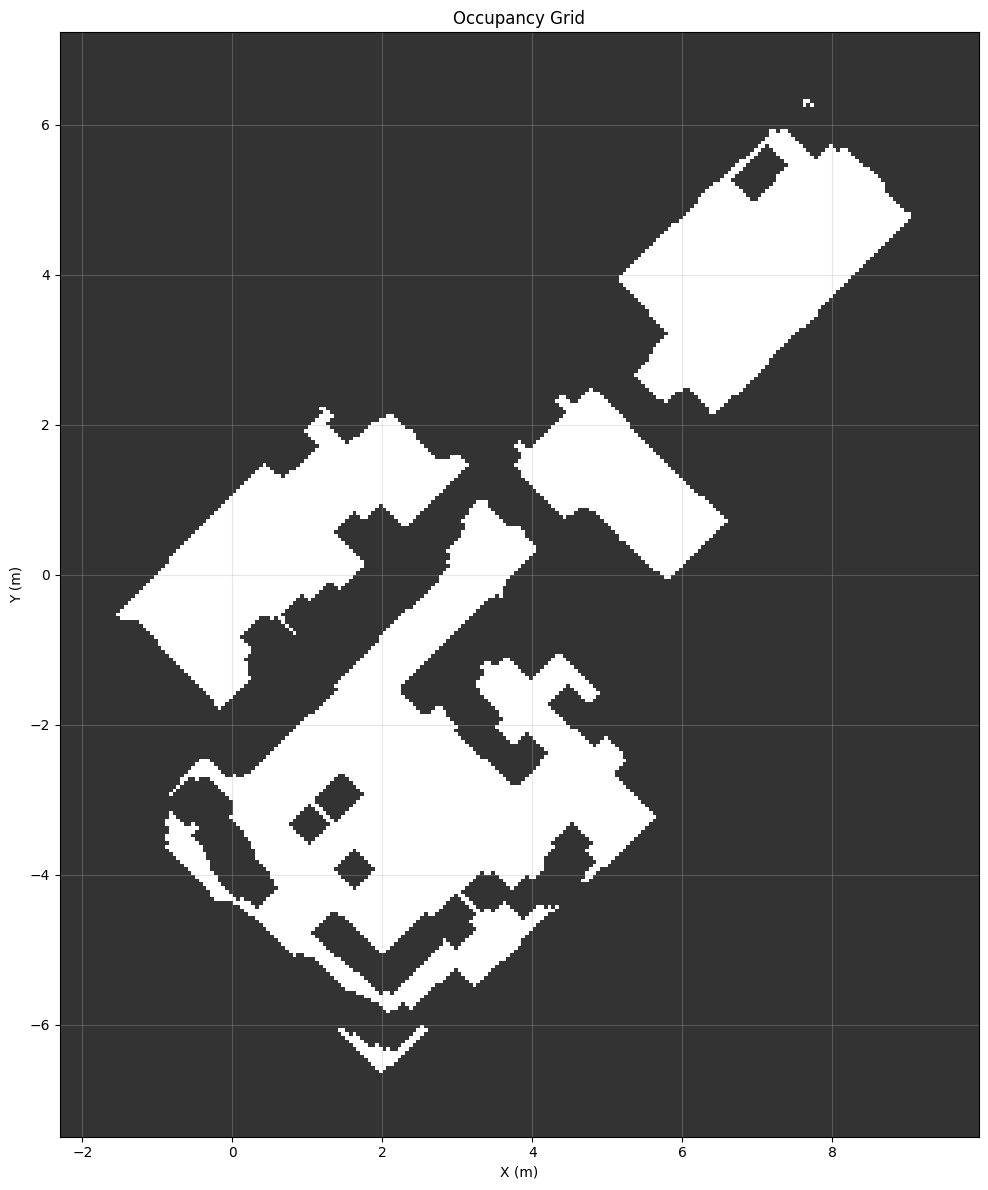

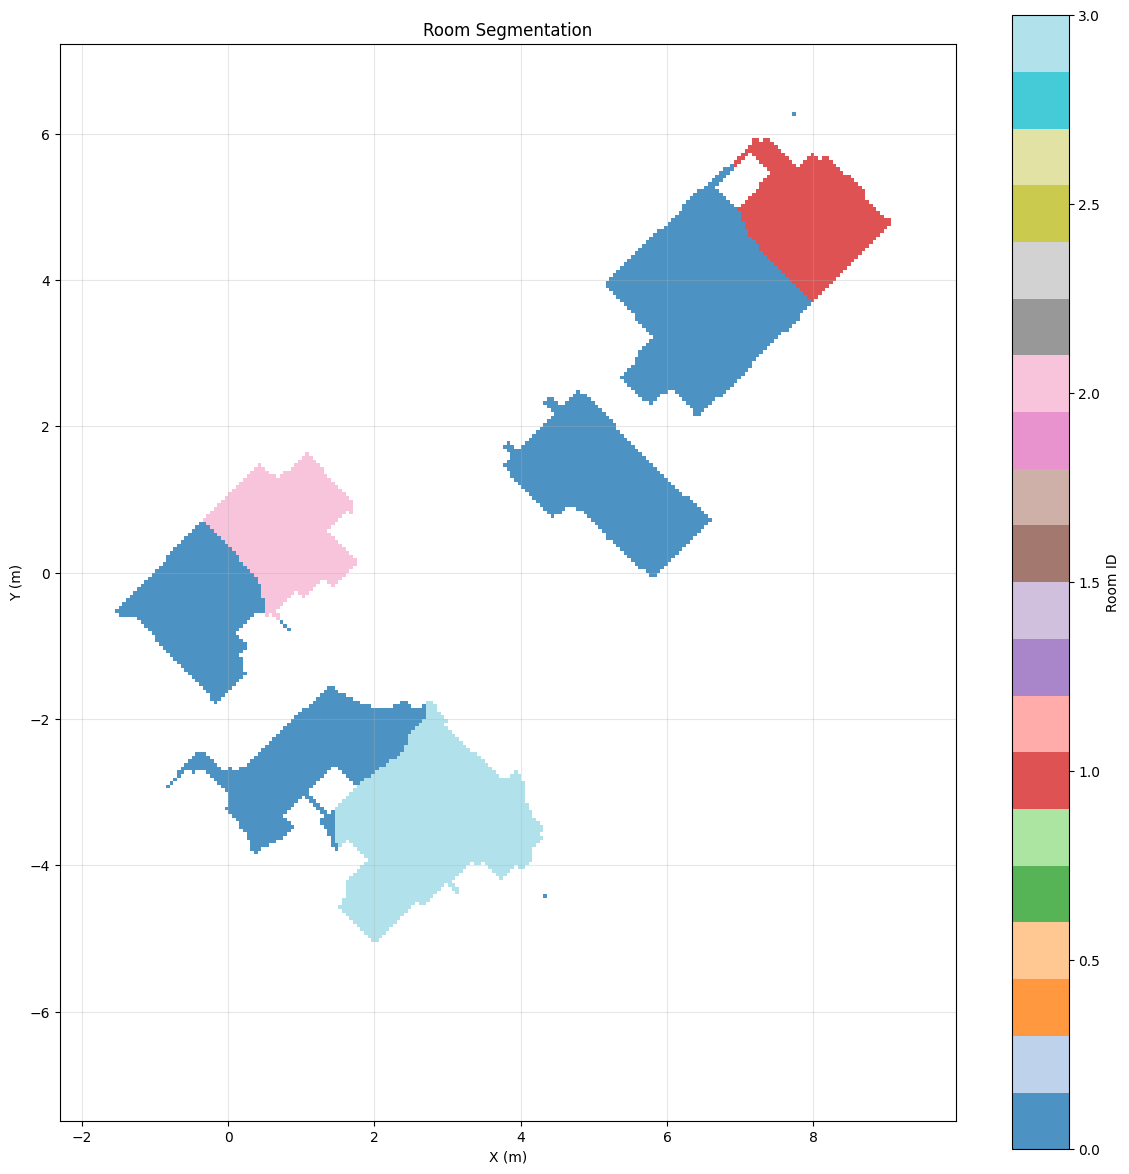

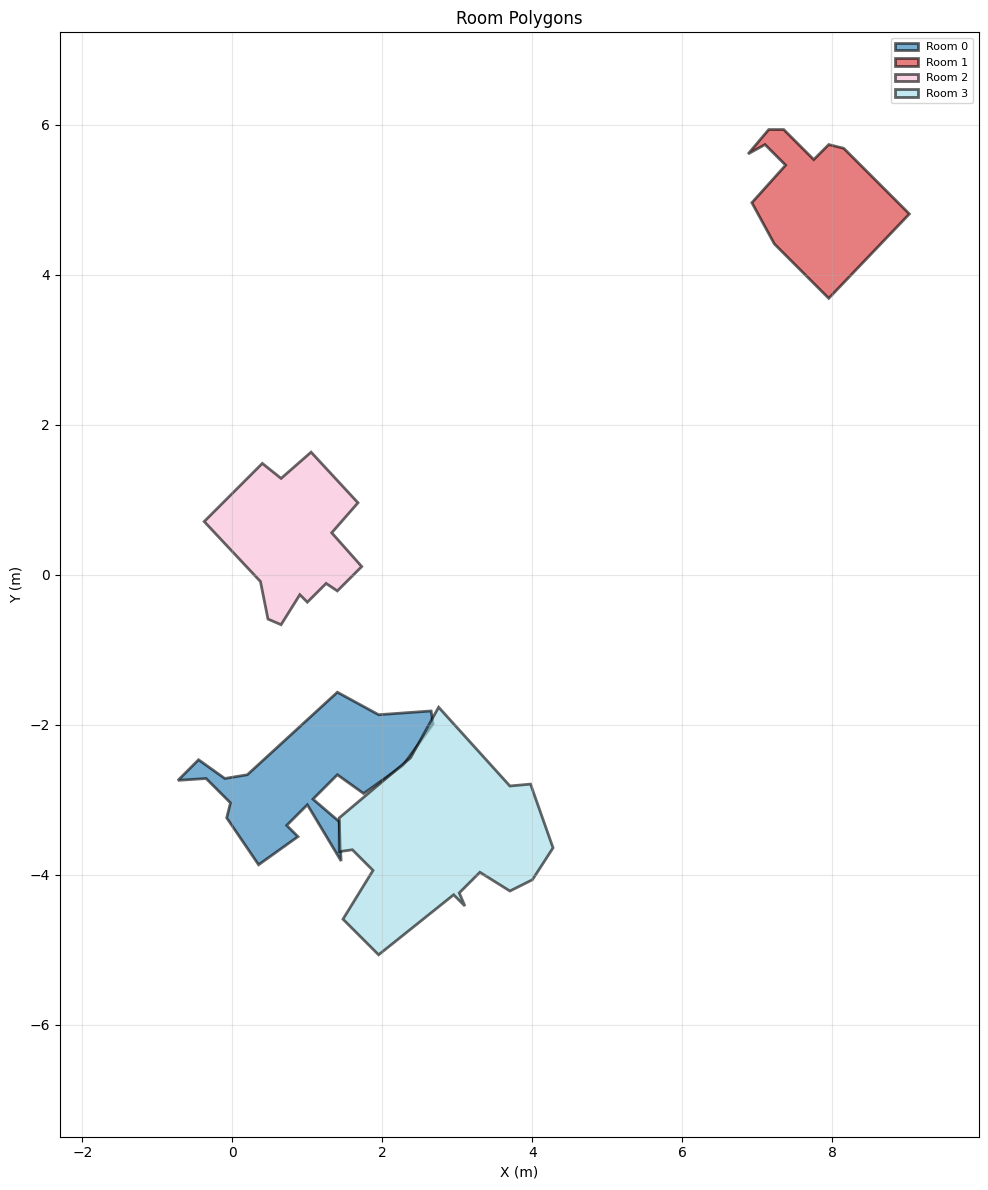

In [87]:
separator = run_room_separation_pipeline(
    vertical_points,
    mode='wall_based',
    grid_resolution=0.05,
    wall_distance_threshold=0.15,
    n_rooms='auto',              # Auto-detect after closing doors
    min_room_area=2.0,
    close_doors=True,            # ✅ NEW: Close doorways
    door_closing_iterations=3,   # ✅ NEW: How much to dilate (3-5 typical)
    show_occupancy=True,
    show_segmentation=True,
    show_polygons=True
)

In [97]:
ceil_mask = sem_seg.ransac_segmentor.segments["ceiling"]["indices"]

In [100]:
ceiling_points_2d = sem_seg.points[ceil_mask][:, :2]

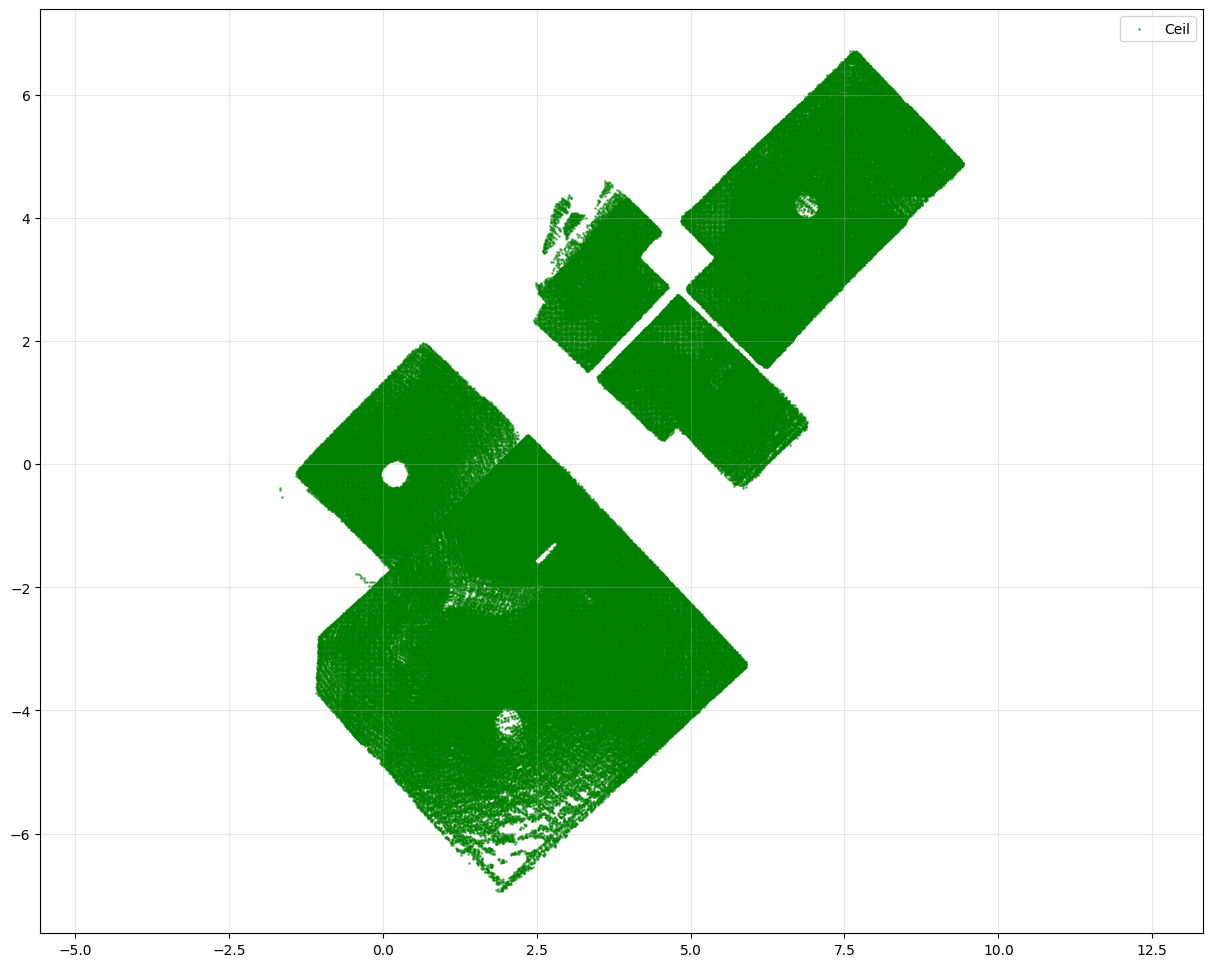

In [102]:
plt.figure(figsize=(15, 12))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Ceil', alpha=0.5)

plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()